In [1]:
!pip3 install -r requirements.txt
# !sudo jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [2]:
!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:16

# Датасет RuCoLa

In [2]:
import pandas as pd

In [3]:
train_dataset = pd.read_csv("./rucola/train.tsv", sep="\t", names=["text", "is_correct", "authored_by", "error_type", "source"])
train_dataset.head()

,text,is_correct,authored_by,error_type,source
0,В 1929 году Ньюкомб переехал на Мальту в качес...,1,Machine,0,WikiMatrix
1,"Вдруг решетка беззвучно поехала в сторону, и н...",1,Expert,0,Paducheva2004
2,Этим летом не никуда ездили.,0,Expert,Syntax,Rusgram
3,В 2011 году был выпущен документальный фильм «...,1,Machine,0,WikiMatrix
4,Поговорительница Пресли поссорилась с поп-звез...,0,Machine,Morphology,WikiMatrix


In [4]:
test_dataset = pd.read_csv("./rucola/dev.tsv", sep="\t", names=["text", "is_correct", "authored_by", "error_type", "source"])
test_dataset.head()

,text,is_correct,authored_by,error_type,source
0,Иван вчера не позвонил.,1,Expert,0,Paducheva2013
1,"У многих туристов, кто посещают Кемер весной, ...",0,Expert,Syntax,USE8
2,"Я бы изобрела транспорт, который бы с сильной ...",0,Natural,Lexis,Tseitlin
3,Когда он заходит на пол американского обмена в...,0,Machine,Hallucination,TED
4,"Американский телесериал, посвященный Хэллоуину...",0,Machine,Hallucination,WikiMatrix


In [6]:
TRAIN_DATA_LENGTH = len(train_dataset)
print(TRAIN_DATA_LENGTH)
TEST_DATA_LENGTH = len(test_dataset)
print(TEST_DATA_LENGTH)

12917
1612


In [5]:
sources = set()
for value in train_dataset["source"]:
    sources.add(value)
for value in test_dataset["source"]:
    sources.add(value)
print(sources)

{'Mitrenina', 'Lutikova', 'Paducheva2004', 'WikiMatrix', 'Tatoeba', 'CoRST', 'USE6', 'USE5', 'Paducheva2013', 'Seliverstova', 'USE7', 'Paducheva1996', 'USE8', 'Tseitlin', 'YandexCorpus', 'Rusgram', 'Testelets', 'TED'}


In [7]:
counter = 0
for value in train_dataset["is_correct"]:
    if value == 0:
        counter += 1
print(f"{counter / TRAIN_DATA_LENGTH:.3f}")

counter = 0
for value in test_dataset["is_correct"]:
    if value == 0:
        counter += 1
print(f"{counter / TEST_DATA_LENGTH:.3f}")

0.398
0.396


Итого предложений с ошибками 40%. Датасет в исходнои виде подходит для бинарной классификации грамматичности

In [8]:
error_types = set()
for value in train_dataset["error_type"]:
    error_types.update([*value.split("|")])
error_types.remove('0')
print(error_types)

error_types = set()
for value in test_dataset["error_type"]:
    error_types.update([*value.split("|")])
error_types.remove('0')
print(error_types)

{'Commonsense', 'Lexis', 'Morphology', 'Hallucination', 'Syntax', 'Semantics'}
{'Commonsense', 'Lexis', 'Morphology', 'Hallucination', 'Syntax', 'Semantics'}


Итого 6 типов ошибок

In [9]:
error_types_stats = {}
for error_type in error_types:
    error_types_stats[error_type] = 0

for value in train_dataset["error_type"]:
    if value == '0':
        continue
    for error_type in value.split("|"):
        error_types_stats[error_type] += 1

for error_type in error_types:
    print(f"{error_type}: {error_types_stats[error_type] / TRAIN_DATA_LENGTH:.3f}")

print("\n")
    
error_types_stats = {}
for error_type in error_types:
    error_types_stats[error_type] = 0

for value in test_dataset["error_type"]:
    if value == '0':
        continue
    for error_type in value.split("|"):
        error_types_stats[error_type] += 1

for error_type in error_types:
    print(f"{error_type}: {error_types_stats[error_type] / TEST_DATA_LENGTH:.3f}")

Commonsense: 0.010
Lexis: 0.085
Morphology: 0.056
Hallucination: 0.037
Syntax: 0.190
Semantics: 0.075


Commonsense: 0.009
Lexis: 0.085
Morphology: 0.055
Hallucination: 0.034
Syntax: 0.192
Semantics: 0.074


In [10]:
machine_counter = 0
for value in train_dataset["authored_by"]:
    if value == "Machine":
        machine_counter += 1

print(f"{machine_counter / TRAIN_DATA_LENGTH:.3f}")


machine_counter = 0
for value in test_dataset["authored_by"]:
    if value == "Machine":
        machine_counter += 1

print(f"{machine_counter / TEST_DATA_LENGTH:.3f}")

0.258
0.257


26% предложений в датасете сгенерированы машиной

## Сводка по датасету

Длина тренировочной части датасета: 12917
Длина тестовой части датасета: 1612


Доля предложений с ошибкой: 0.4

Виды ошибок: {'Semantics', 'Commonsense', 'Morphology', 'Hallucination', 'Syntax', 'Lexis'}

Доля каждого вида ошибок (взяты с тренировочной части; совпадают в пределах погрешности с тестовой частью):
    Semantics: 0.075
    Commonsense: 0.010
    Morphology: 0.056
    Hallucination: 0.037
    Syntax: 0.190
    Lexis: 0.085
   
Доля сгенерированных машиной предложений: 0.258

# Классификаторы:

In [11]:
train_dataset.to_csv("./rucola/train.csv")
test_dataset.to_csv("./rucola/test.csv")

## Классификатор грамматичности

Основной классификатор, определяющий наличие ошибки любого рода в предложении

In [12]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files={'train': './rucola/train.csv', 'test': './rucola/test.csv'})
column_names = dataset["train"].column_names
column_names.remove("is_correct")
column_names.remove("text")
dataset["train"] = dataset["train"].remove_columns(column_names)
dataset["test"] = dataset["test"].remove_columns(column_names)
dataset["train"] = dataset["train"].rename_column("is_correct", "label")
dataset["test"] = dataset["test"].rename_column("is_correct", "label")
dataset["train"][100]

Using custom data configuration default-081ceb0bf9c7c7cd


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/bart/.cache/huggingface/datasets/csv/default-081ceb0bf9c7c7cd/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

{'text': 'Он перецеловал всех девушек.', 'label': 1}

In [ ]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"]
small_eval_dataset = tokenized_datasets["test"]

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2", num_labels=2)

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", per_device_train_batch_size=2, per_device_eval_batch_size=2)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
import torch
torch.cuda.empty_cache()
trainer.train()

Epoch	    Training Loss   Validation Loss    	Accuracy

1	             0.820300	       0.684045	               0.688586

2	             0.793900	       1.073257	               0.683623

3	             0.750300	       1.383223            	   0.690447

Очевидно, модель переобучилась. Попробуем исправить это недоразумение

In [ ]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files={'train': './rucola/train.csv', 'test': './rucola/test.csv'})

column_names = dataset["train"].column_names
column_names.remove("is_correct")
column_names.remove("text")

dataset["train"] = dataset["train"].remove_columns(column_names)
dataset["test"] = dataset["test"].remove_columns(column_names)

dataset["train"] = dataset["train"].rename_column("is_correct", "label")
dataset["test"] = dataset["test"].rename_column("is_correct", "label")

dataset["train"][100]

In [ ]:
import copy
import numpy as np

import torch
from sklearn.model_selection import StratifiedKFold
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from datasets import load_metric
from transformers import TrainingArguments, Trainer, AutoTokenizer


# First make the kfold object
folds = StratifiedKFold(n_splits=5)

# Then get the dataset
datasets = dataset

# Now make our splits based off of the labels. 
# We can use `np.zeros()` here since it only works off of indices, we really care about the labels
splits = folds.split(np.zeros(datasets["train"].num_rows), datasets["train"]["label"])

# Finally, do what you want with it
# In this case I'm overriding the train/val/test

model = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2", num_labels=2, attention_probs_dropout_prob=0.3,
        hidden_dropout_prob=0.3)
f1_metric = load_metric("f1")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
accuracy_metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision = precision_metric.compute(predictions=predictions, references=labels)["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels)["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels)["f1"]
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(output_dir="test_trainer_cross_val", evaluation_strategy="epoch", learning_rate=3e-6, num_train_epochs=3, per_device_train_batch_size=2, per_device_eval_batch_size=2)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

for train_idxs, val_idxs in splits:
    datasets = copy.deepcopy(dataset)
    #datasets["test"] = datasets["validation"]
    datasets["test"] = datasets["train"].select(val_idxs)
    datasets["train"] = datasets["train"].select(train_idxs)

    tokenized_datasets = datasets.map(tokenize_function, batched=True)

    small_train_dataset = tokenized_datasets["train"]
    small_eval_dataset = tokenized_datasets["test"]
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset,
        compute_metrics=compute_metrics,
    )
    
    torch.cuda.empty_cache()
    trainer.train()


In [ ]:
a = next(iter(splits))
print(a[0].shape)
print(a[1].shape)

In [ ]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
div#notebook-container { width: 95%; }
div#menubar-container { width: 65%; }
div#maintoolbar-container { width: 99%; }
</style>
"""))

%matplotlib inline

In [ ]:
import copy
import numpy as np

import torch
from sklearn.model_selection import StratifiedKFold
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from datasets import load_metric
from transformers import TrainingArguments, Trainer, AutoTokenizer
from transformers.utils import logging




# First make the kfold object
# folds = StratifiedKFold(n_splits=5)

# Then get the dataset
!export TRANSFORMERS_NO_ADVISORY_WARNINGS=1
datasets = dataset

# Now make our splits based off of the labels. 
# We can use `np.zeros()` here since it only works off of indices, we really care about the labels
# splits = folds.split(np.zeros(datasets["train"].num_rows), datasets["train"]["label"])

# Finally, do what you want with it
# In this case I'm overriding the train/val/test

model = AutoModelForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny2",
    num_labels=2,
    attention_probs_dropout_prob=0.3,
    hidden_dropout_prob=0.3,
    classifier_dropout=0.3
)

f1_metric = load_metric("f1")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
accuracy_metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision = precision_metric.compute(predictions=predictions, references=labels)["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels)["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels)["f1"]
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="test_trainer_cross_val",
    evaluation_strategy="epoch",
    num_train_epochs=18,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=3e-7,
    # log_level="error",
    logging_first_step=True,
)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")


datasets = copy.deepcopy(dataset)
# #datasets["test"] = datasets["validation"]
# datasets["test"] = datasets["test"]
# datasets["train"] = datasets["train"]

tokenized_datasets = datasets.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"]
small_eval_dataset = tokenized_datasets["test"]

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

torch.cuda.empty_cache()
print("Start training")
trainer.train()


In [ ]:
training_args = TrainingArguments(
    output_dir="test_trainer_cross_val",
    evaluation_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=1e-7,
    # log_level="error",
    logging_first_step=True,
)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")


datasets = copy.deepcopy(dataset)
# #datasets["test"] = datasets["validation"]
# datasets["test"] = datasets["test"]
# datasets["train"] = datasets["train"]

tokenized_datasets = datasets.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"]
small_eval_dataset = tokenized_datasets["test"]

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)


print("Start training")
trainer.train()


In [ ]:
print(type(datasets))

In [ ]:
# pip install transformers sentencepiece
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
model.cuda()  # uncomment it if you have a GPU

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    print(t)
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

print(torch.cuda.is_available())
print(embed_bert_cls('привет, мир', model, tokenizer) == embed_bert_cls('привет мир', model, tokenizer))
# (312,)

In [ ]:
!ls

In [ ]:
contains_error_model = AutoModelForSequenceClassification.from_pretrained("./test_trainer_cross_val/checkpoint-26000")
contains_error_tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

In [ ]:
class ContainsErrorClassifier:
    def __init__(self, model, tokenizer):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        print(f"Model device: {self.device}")
        self.tokenizer = tokenizer
        self.model = model
        
    def _gen_batch(self, inputs, batch_size):
        batch_start = 0
        while batch_start < len(inputs):
            yield inputs[batch_start: batch_start + batch_size]
            batch_start += batch_size


    def predict(
        self,
        input_records,
        max_source_tokens_count=600,
        batch_size=4,
        print_batch_results=False,
        save_in_file=False,
        output_file="MBartSummarizerOutput.txt"
    ):
        labels = []
        for input_record in input_records:
            inputs = self.tokenizer(input_record, return_tensors="pt").to(self.device)

            with torch.no_grad():
                logits = self.model(**inputs).logits
            # print(logits)

            predicted_class_id = logits.argmax().item()
            # print(predicted_class_id)
            labels.append(1 if self.model.config.id2label[predicted_class_id] == 'LABEL_1' else 0)
        
        return labels
    
    def save(self, predictions, output_file, output_mode="w"):
        with open(output_file, output_mode) as w:
            for p in predictions:
                w.write(p.strip().replace("\n", " ") + "\n")

In [ ]:
contains_error_model = AutoModelForSequenceClassification.from_pretrained("./test_trainer_cross_val/checkpoint-26000", num_labels=2)
contains_error_model.cuda()
contains_error_tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

In [ ]:
HasErrorClassifier = ContainsErrorClassifier(contains_error_model, contains_error_tokenizer)

In [ ]:
datasets["train"]["text"][0:10], datasets["train"]["label"][0:10]

In [ ]:
print(HasErrorClassifier.predict(datasets["test"]["text"][0:100]))
print(datasets["test"]["label"][0:100])

# Syntax Error Classifier

In [1]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files={'train': './rucola/train.csv', 'test': './rucola/test.csv'})



Using custom data configuration default-081ceb0bf9c7c7cd
Reusing dataset csv (/home/bart/.cache/huggingface/datasets/csv/default-081ceb0bf9c7c7cd/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
error_type = "Syntax"
syntax_train_column = []
syntax_test_column = []
for row in dataset["train"]:
    if error_type in row["error_type"]:
        syntax_train_column.append(1)
    else:
        syntax_train_column.append(0)
        
for row in dataset["test"]:
    if error_type in row["error_type"]:
        syntax_test_column.append(1)
    else:
        syntax_test_column.append(0)

dataset["train"] = dataset["train"].add_column("label", syntax_train_column)
dataset["test"] = dataset["test"].add_column("label", syntax_test_column)

In [3]:
dataset["train"][10]

{'Unnamed: 0': 10,
 'text': 'Мне предоставилась возможность все видеть, сам оставаясь незамеченным.',
 'is_correct': 0,
 'authored_by': 'Expert',
 'error_type': 'Syntax',
 'source': 'Testelets',
 'label': 1}

In [4]:
column_names = dataset["train"].column_names
column_names.remove("label")
column_names.remove("text")

dataset["train"] = dataset["train"].remove_columns(column_names)
dataset["test"] = dataset["test"].remove_columns(column_names)

dataset["train"][10]

{'text': 'Мне предоставилась возможность все видеть, сам оставаясь незамеченным.',
 'label': 1}

In [ ]:
import copy
import numpy as np

import torch
from sklearn.model_selection import StratifiedKFold
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from datasets import load_metric
from transformers import TrainingArguments, Trainer, AutoTokenizer
from transformers.utils import logging




# First make the kfold object
# folds = StratifiedKFold(n_splits=5)

# Then get the dataset
!export TRANSFORMERS_NO_ADVISORY_WARNINGS=1
datasets = dataset

# Now make our splits based off of the labels. 
# We can use `np.zeros()` here since it only works off of indices, we really care about the labels
# splits = folds.split(np.zeros(datasets["train"].num_rows), datasets["train"]["label"])

# Finally, do what you want with it
# In this case I'm overriding the train/val/test

model = AutoModelForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny2",
    num_labels=2,
    attention_probs_dropout_prob=0.3,
    hidden_dropout_prob=0.3,
    classifier_dropout=0.3
)

f1_metric = load_metric("f1")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
accuracy_metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision = precision_metric.compute(predictions=predictions, references=labels)["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels)["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels)["f1"]
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="syntax_error_classifier_checkpoints",
    evaluation_strategy="epoch",
    num_train_epochs=18,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=1e-5,
    # log_level="error",
    logging_first_step=True,
)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")


datasets = copy.deepcopy(dataset)
# #datasets["test"] = datasets["validation"]
# datasets["test"] = datasets["test"]
# datasets["train"] = datasets["train"]

tokenized_datasets = datasets.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"]
small_eval_dataset = tokenized_datasets["test"]

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

torch.cuda.empty_cache()
print("Start training")
trainer.train()

In [ ]:
import copy
import numpy as np

import torch
from sklearn.model_selection import StratifiedKFold
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from datasets import load_metric
from transformers import TrainingArguments, Trainer, AutoTokenizer
from transformers.utils import logging




# First make the kfold object
# folds = StratifiedKFold(n_splits=5)

# Then get the dataset
!export TRANSFORMERS_NO_ADVISORY_WARNINGS=1
datasets = dataset

# Now make our splits based off of the labels. 
# We can use `np.zeros()` here since it only works off of indices, we really care about the labels
# splits = folds.split(np.zeros(datasets["train"].num_rows), datasets["train"]["label"])

# Finally, do what you want with it
# In this case I'm overriding the train/val/test

model = AutoModelForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny2",
    num_labels=2,
    attention_probs_dropout_prob=0.3,
    hidden_dropout_prob=0.3,
    classifier_dropout=0.3
)

f1_metric = load_metric("f1")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
accuracy_metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision = precision_metric.compute(predictions=predictions, references=labels)["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels)["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels)["f1"]
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="syntax_error_1e6_classifier_checkpoints",
    evaluation_strategy="epoch",
    num_train_epochs=18,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=1e-6,
    # log_level="error",
    logging_first_step=True,
)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")


datasets = copy.deepcopy(dataset)
# #datasets["test"] = datasets["validation"]
# datasets["test"] = datasets["test"]
# datasets["train"] = datasets["train"]

tokenized_datasets = datasets.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"]
small_eval_dataset = tokenized_datasets["test"]

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

torch.cuda.empty_cache()
print("Start training")
trainer.train()

In [ ]:
training_args = TrainingArguments(
    output_dir="syntax_error_1e6_classifier_checkpoints",
    evaluation_strategy="epoch",
    num_train_epochs=40,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=1e-6,
    # log_level="error",
    logging_first_step=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

print("Continue training")
trainer.train()

Saving model checkpoint to syntax_error_1e6_classifier_checkpoints/checkpoint-58500
Configuration saved in syntax_error_1e6_classifier_checkpoints/checkpoint-58500/config.json
Model weights saved in syntax_error_1e6_classifier_checkpoints/checkpoint-58500/pytorch_model.bin

Saving model checkpoint to syntax_error_1e6_classifier_checkpoints/checkpoint-52000
Configuration saved in syntax_error_1e6_classifier_checkpoints/checkpoint-52000/config.json
Model weights saved in syntax_error_1e6_classifier_checkpoints/checkpoint-52000/pytorch_model.bin

In [7]:
import copy
import numpy as np

import torch
from sklearn.model_selection import StratifiedKFold
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from datasets import load_metric
from transformers import TrainingArguments, Trainer, AutoTokenizer
from transformers.utils import logging

contains_syntax_error_model = AutoModelForSequenceClassification.from_pretrained("./syntax_error_1e6_classifier_checkpoints/checkpoint-52000", num_labels=2)
contains_syntax_error_model.cuda()
contains_syntax_error_tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

loading configuration file ./syntax_error_1e6_classifier_checkpoints/checkpoint-52000/config.json
Model config BertConfig {
  "_name_or_path": "./syntax_error_1e6_classifier_checkpoints/checkpoint-52000",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.3,
  "classifier_dropout": 0.3,
  "emb_size": 312,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 312,
  "initializer_range": 0.02,
  "intermediate_size": 600,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 2048,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 3,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 83828
}

loading weights file ./syntax_error_1e6_classifier_checkpoints/checkpoint-52000/pytorch_mode

In [ ]:
import copy
import numpy as np

import torch
from sklearn.model_selection import StratifiedKFold
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from datasets import load_metric
from transformers import TrainingArguments, Trainer, AutoTokenizer
from transformers.utils import logging



# Then get the dataset
!export TRANSFORMERS_NO_ADVISORY_WARNINGS=1
datasets = dataset


f1_metric = load_metric("f1")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
accuracy_metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision = precision_metric.compute(predictions=predictions, references=labels)["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels)["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels)["f1"]
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="syntax_error_1e7_classifier_checkpoints",
    evaluation_strategy="epoch",
    num_train_epochs=20,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=3e-8,
    # log_level="error",
    logging_first_step=True,
)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")


datasets = copy.deepcopy(dataset)
# #datasets["test"] = datasets["validation"]
# datasets["test"] = datasets["test"]
# datasets["train"] = datasets["train"]

tokenized_datasets = datasets.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"]
small_eval_dataset = tokenized_datasets["test"]

trainer = Trainer(
    model=contains_syntax_error_model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

# torch.cuda.empty_cache()
print("Start training")
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading file https://huggingface.co/cointegrated/rubert-tiny2/resolve/main/vocab.txt from cache at /home/bart/.cache/huggingface/transformers/16af2afaa4ceaa8d50b689bd4c2f7ef7fe3bfac06c0aac7d82a5c1c72298b62a.cc3312d07ccf88871a3c2b7cb3442138e6785101efead94d9f77e96301cf7f4a
loading file https://huggingface.co/cointegrated/rubert-tiny2/resolve/main/tokenizer.json from cache at /home/bart/.cache/huggingface/transformers/cfa6d82dc8ecc7fe3f06deb449f38968cdd188bb84c8da0e06f0bbfddbede1e3.550ab7157d36210bf96c7c3b30e621933d37d635c5f2e290f7e88bd5f7c9198a
loading file https://huggingface.co/cointegrated/rubert-tiny2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/cointeg

  0%|          | 0/2 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/bart/.local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12917
  Num Epochs = 20
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 129180


Start training


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.642700,0.665467,0.826303,0.600000,0.281553,0.383260
2,0.676500,0.666299,0.826303,0.600000,0.281553,0.383260
3,0.671100,0.666341,0.826303,0.600000,0.281553,0.383260
4,0.570200,0.666733,0.826923,0.602740,0.284790,0.386813
5,0.608800,0.667123,0.826923,0.602740,0.284790,0.386813
6,0.605900,0.667563,0.826303,0.598639,0.284790,0.385965
7,0.635600,0.668085,0.826303,0.598639,0.284790,0.385965
8,0.669400,0.668414,0.826303,0.598639,0.284790,0.385965
9,0.634400,0.668707,0.826303,0.598639,0.284790,0.385965
10,0.685600,0.668980,0.826923,0.601351,0.288026,0.389497


Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-500
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-500/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-500/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-1000
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-1000/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-1500
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-1500/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-2000
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-2000/config.json
Model weights sa

Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-14500
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-14500/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-14500/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-15000
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-15000/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-15000/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-15500
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-15500/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-15500/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-16000
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-16000/config.json
Mo

Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-28000/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-28500
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-28500/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-28500/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-29000
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-29000/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-29000/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-29500
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-29500/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-29500/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-30

Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-42000/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-42000/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-42500
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-42500/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-42500/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-43000
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-43000/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-43000/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-43500
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-43500/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-43500/pytorc

Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-56000
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-56000/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-56000/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-56500
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-56500/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-56500/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-57000
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-57000/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-57000/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-57500
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-57500/config.json
Mo

Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-69500/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-70000
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-70000/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-70000/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-70500
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-70500/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-70500/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-71000
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-71000/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-71000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument

Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-83500/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-83500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1612
  Batch size = 2
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-84000
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-84000/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-84000/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-84500
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-84500/config.json
Model weights saved in syntax_e

***** Running Evaluation *****
  Num examples = 1612
  Batch size = 2
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-97000
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-97000/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-97000/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-97500
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-97500/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-97500/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-98000
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-98000/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-98000/pytorch_model.bin
Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-98500
Configuration saved in s

Saving model checkpoint to syntax_error_1e7_classifier_checkpoints/checkpoint-6500
Configuration saved in syntax_error_1e7_classifier_checkpoints/checkpoint-6500/config.json
Model weights saved in syntax_error_1e7_classifier_checkpoints/checkpoint-6500/pytorch_model.bin

# Semantics Error Classifier

In [1]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files={'train': './rucola/train.csv', 'test': './rucola/test.csv'})


Using custom data configuration default-081ceb0bf9c7c7cd
Reusing dataset csv (/home/bart/.cache/huggingface/datasets/csv/default-081ceb0bf9c7c7cd/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
error_type = "Semantics"
syntax_train_column = []
syntax_test_column = []
for row in dataset["train"]:
    if error_type in row["error_type"]:
        syntax_train_column.append(1)
    else:
        syntax_train_column.append(0)
        
for row in dataset["test"]:
    if error_type in row["error_type"]:
        syntax_test_column.append(1)
    else:
        syntax_test_column.append(0)

dataset["train"] = dataset["train"].add_column("label", syntax_train_column)
dataset["test"] = dataset["test"].add_column("label", syntax_test_column)

In [3]:
column_names = dataset["train"].column_names
column_names.remove("label")
column_names.remove("text")

dataset["train"] = dataset["train"].remove_columns(column_names)
dataset["test"] = dataset["test"].remove_columns(column_names)

dataset["train"][10]

{'text': 'Мне предоставилась возможность все видеть, сам оставаясь незамеченным.',
 'label': 0}

In [7]:
for i in range(10):
    print(dataset["train"][30 + i])

{'text': 'Они хотят, чтобы я разговаривал с вами.', 'label': 0}
{'text': 'Через четверть часа он уже сидел в ресторане.', 'label': 0}
{'text': 'Как я заметил еще из окна, каждый из них что-то нес.', 'label': 0}
{'text': 'Придет он или нет, зависит от ряда обстоятельств.', 'label': 0}
{'text': 'Ценность сведений установилась на основе предпочтений.', 'label': 1}
{'text': 'Они приняли во внимание слухи, что Аня предаст Катю.', 'label': 0}
{'text': 'На повороте дороги показалась коляска.', 'label': 0}
{'text': 'Ученые заявили об истощении людей до степени худобы при отсутствии еды и воды.', 'label': 1}
{'text': 'Он немедленно не ушел.', 'label': 1}
{'text': 'Пиво он любит темное.', 'label': 0}


Попробуем обучить классификатор без манипуляций с данными (спойлер - не учится)

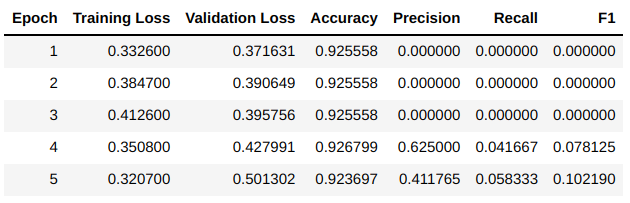

In [20]:
from datasets import Dataset, concatenate_datasets, load_dataset

new_part = {
    "text": [],
    "label": []
}

for row in dataset["train"]:
    if row["label"] == 1: 
        for i in range(3):
            new_part["text"].append(row["text"])
            new_part["label"].append(row["label"])

dataset["train"] = concatenate_datasets([dataset["train"], Dataset.from_dict(new_part)])

In [21]:
print(len(dataset["train"]))

15833


In [24]:
counter = 0

for row in dataset["train"]:
    if row["label"] == 1: 
        counter += 1

print(counter/len(dataset["train"]))

0.2455630644855681


In [28]:
import copy
import numpy as np

import torch
from sklearn.model_selection import StratifiedKFold
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from datasets import load_metric
from transformers import TrainingArguments, Trainer, AutoTokenizer
from transformers.utils import logging


# Then get the dataset
!export TRANSFORMERS_NO_ADVISORY_WARNINGS=1
datasets = dataset


model = AutoModelForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny2",
    num_labels=2,
    attention_probs_dropout_prob=0.3,
    hidden_dropout_prob=0.3,
    classifier_dropout=0.3
)

f1_metric = load_metric("f1")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
accuracy_metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision = precision_metric.compute(predictions=predictions, references=labels)["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels)["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels)["f1"]
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="semantics_error_classifier_checkpoints",
    evaluation_strategy="epoch",
    num_train_epochs=18,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=1e-7,
    # log_level="error",
    logging_first_step=True,
)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")


datasets = copy.deepcopy(dataset)

tokenized_datasets = datasets.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"]
small_eval_dataset = tokenized_datasets["test"]

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading configuration file https://huggingface.co/cointegrated/rubert-tiny2/resolve/main/config.json from cache at /home/bart/.cache/huggingface/transformers/726139048d10597682731a7a4c0b8ef0382927911bc0f6f050a4f7f0afb04c2a.149cdc07694f3925e290abc5528c57a543bcbc9af955c0202b1028584ad15cb4
Model config BertConfig {
  "_name_or_path": "cointegrated/rubert-tiny2",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.3,
  "classifier_dropout": 0.3,
  "emb_size": 312,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 312,
  "initializer_range": 0.02,
  "intermediate_size": 600,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 2048,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 3,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 8382

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [29]:
print("Start training")
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/bart/.local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 15833
  Num Epochs = 18
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 142506


Start training


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.631100,0.565289,0.925558,0.000000,0.000000,0.000000
2,0.577200,0.473557,0.925558,0.000000,0.000000,0.000000
3,0.551800,0.402639,0.925558,0.000000,0.000000,0.000000
4,0.533000,0.350430,0.925558,0.000000,0.000000,0.000000
5,0.541000,0.314479,0.925558,0.000000,0.000000,0.000000
6,0.550600,0.291373,0.925558,0.000000,0.000000,0.000000
7,0.598000,0.276761,0.925558,0.000000,0.000000,0.000000
8,0.642300,0.268387,0.925558,0.000000,0.000000,0.000000
9,0.685200,0.264257,0.925558,0.000000,0.000000,0.000000
10,0.557600,0.262681,0.925558,0.000000,0.000000,0.000000


Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-500
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-500/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-500/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-1000
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-1000/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-1500
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-1500/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-2000
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-2000/config.json
Model weights saved in sema

Configuration saved in semantics_error_classifier_checkpoints/checkpoint-14500/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-14500/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-15000
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-15000/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-15000/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-15500
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-15500/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-15500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Runni

Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-27500
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-27500/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-27500/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-28000
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-28000/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-28000/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-28500
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-28500/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-28500/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-29000
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-29000/config.json
Model weights

Model weights saved in semantics_error_classifier_checkpoints/checkpoint-40000/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-40500
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-40500/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-40500/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-41000
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-41000/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-41000/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-41500
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-41500/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-41500/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-42000
Configu

Model weights saved in semantics_error_classifier_checkpoints/checkpoint-54000/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-54500
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-54500/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-54500/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-55000
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-55000/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-55000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1612
  Batch size = 2
/home/bart/.local/lib/python3.9/

Configuration saved in semantics_error_classifier_checkpoints/checkpoint-67000/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-67000/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-67500
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-67500/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-67500/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-68000
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-68000/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-68000/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-68500
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-68500/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-68500/pytorch_model.bin

Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-80000
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-80000/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-80000/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-80500
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-80500/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-80500/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-81000
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-81000/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-81000/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-81500
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-81500/config.json
Model weights

Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-94000
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-94000/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-94000/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-94500
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-94500/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-94500/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-95000
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-95000/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-95000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertF

Model weights saved in semantics_error_classifier_checkpoints/checkpoint-106500/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-107000
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-107000/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-107000/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-107500
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-107500/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-107500/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-108000
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-108000/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-108000/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-108

Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-119500
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-119500/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-119500/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-120000
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-120000/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-120000/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-120500
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-120500/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-120500/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-121000
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-121000/config.json
Mo

Model weights saved in semantics_error_classifier_checkpoints/checkpoint-133000/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-133500
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-133500/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-133500/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-134000
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-134000/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-134000/pytorch_model.bin
Saving model checkpoint to semantics_error_classifier_checkpoints/checkpoint-134500
Configuration saved in semantics_error_classifier_checkpoints/checkpoint-134500/config.json
Model weights saved in semantics_error_classifier_checkpoints/checkpoint-134500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument

TrainOutput(global_step=142506, training_loss=0.6484119539863377, metrics={'train_runtime': 27794.1654, 'train_samples_per_second': 10.254, 'train_steps_per_second': 5.127, 'total_flos': 8406418971672576.0, 'train_loss': 0.6484119539863377, 'epoch': 18.0})

# Machine Text Classifier

In [1]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files={'train': './rucola/train.csv', 'test': './rucola/test.csv'})

Using custom data configuration default-081ceb0bf9c7c7cd
Reusing dataset csv (/home/bart/.cache/huggingface/datasets/csv/default-081ceb0bf9c7c7cd/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
error_type = "Machine"
syntax_train_column = []
syntax_test_column = []
for row in dataset["train"]:
    if error_type in row["authored_by"]:
        syntax_train_column.append(1)
    else:
        syntax_train_column.append(0)
        
for row in dataset["test"]:
    if error_type in row["authored_by"]:
        syntax_test_column.append(1)
    else:
        syntax_test_column.append(0)

dataset["train"] = dataset["train"].add_column("label", syntax_train_column)
dataset["test"] = dataset["test"].add_column("label", syntax_test_column)

In [3]:
column_names = dataset["train"].column_names
column_names.remove("label")
column_names.remove("text")

dataset["train"] = dataset["train"].remove_columns(column_names)
dataset["test"] = dataset["test"].remove_columns(column_names)

dataset["train"][10]

{'text': 'Мне предоставилась возможность все видеть, сам оставаясь незамеченным.',
 'label': 0}

In [4]:
for i in range(10):
    print(dataset["train"][30 + i])

{'text': 'Они хотят, чтобы я разговаривал с вами.', 'label': 1}
{'text': 'Через четверть часа он уже сидел в ресторане.', 'label': 0}
{'text': 'Как я заметил еще из окна, каждый из них что-то нес.', 'label': 0}
{'text': 'Придет он или нет, зависит от ряда обстоятельств.', 'label': 0}
{'text': 'Ценность сведений установилась на основе предпочтений.', 'label': 0}
{'text': 'Они приняли во внимание слухи, что Аня предаст Катю.', 'label': 0}
{'text': 'На повороте дороги показалась коляска.', 'label': 0}
{'text': 'Ученые заявили об истощении людей до степени худобы при отсутствии еды и воды.', 'label': 1}
{'text': 'Он немедленно не ушел.', 'label': 0}
{'text': 'Пиво он любит темное.', 'label': 0}


In [5]:
counter = 0

for row in dataset["train"]:
    if row["label"] == 1: 
        counter += 1

print(counter/len(dataset["train"]))

0.2582643028567005


In [7]:
import copy
import numpy as np

import torch
from sklearn.model_selection import StratifiedKFold
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from datasets import load_metric
from transformers import TrainingArguments, Trainer, AutoTokenizer
from transformers.utils import logging


# Then get the dataset
!export TRANSFORMERS_NO_ADVISORY_WARNINGS=1
datasets = dataset


model = AutoModelForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny2",
    num_labels=2,
    attention_probs_dropout_prob=0.3,
    hidden_dropout_prob=0.3,
    classifier_dropout=0.3
)

f1_metric = load_metric("f1")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
accuracy_metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision = precision_metric.compute(predictions=predictions, references=labels)["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels)["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels)["f1"]
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="Machine_text_classifier_checkpoints",
    evaluation_strategy="epoch",
    num_train_epochs=18,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=1e-6,
    # log_level="error",
    logging_first_step=True,
)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")


datasets = copy.deepcopy(dataset)

tokenized_datasets = datasets.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"]
small_eval_dataset = tokenized_datasets["test"]

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading configuration file https://huggingface.co/cointegrated/rubert-tiny2/resolve/main/config.json from cache at /home/bart/.cache/huggingface/transformers/726139048d10597682731a7a4c0b8ef0382927911bc0f6f050a4f7f0afb04c2a.149cdc07694f3925e290abc5528c57a543bcbc9af955c0202b1028584ad15cb4
Model config BertConfig {
  "_name_or_path": "cointegrated/rubert-tiny2",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.3,
  "classifier_dropout": 0.3,
  "emb_size": 312,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 312,
  "initializer_range": 0.02,
  "intermediate_size": 600,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 2048,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 3,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 8382

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [8]:
print("Start training")
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/bart/.local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12917
  Num Epochs = 18
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 116262


Start training


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.580300,0.613922,0.743176,0.000000,0.000000,0.000000
2,0.540000,0.577272,0.810794,0.865772,0.311594,0.458259
3,0.577600,0.589346,0.831886,0.784861,0.475845,0.592481
4,0.553200,0.626278,0.837469,0.783582,0.507246,0.615836
5,0.637400,0.628822,0.841191,0.788321,0.521739,0.627907
6,0.554400,0.623779,0.842432,0.787770,0.528986,0.632948
7,0.504600,0.632247,0.848015,0.796491,0.548309,0.649499


Saving model checkpoint to Machine_text_classifier_checkpoints/checkpoint-500
Configuration saved in Machine_text_classifier_checkpoints/checkpoint-500/config.json
Model weights saved in Machine_text_classifier_checkpoints/checkpoint-500/pytorch_model.bin
Saving model checkpoint to Machine_text_classifier_checkpoints/checkpoint-1000
Configuration saved in Machine_text_classifier_checkpoints/checkpoint-1000/config.json
Model weights saved in Machine_text_classifier_checkpoints/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to Machine_text_classifier_checkpoints/checkpoint-1500
Configuration saved in Machine_text_classifier_checkpoints/checkpoint-1500/config.json
Model weights saved in Machine_text_classifier_checkpoints/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to Machine_text_classifier_checkpoints/checkpoint-2000
Configuration saved in Machine_text_classifier_checkpoints/checkpoint-2000/config.json
Model weights saved in Machine_text_classifier_checkpoints/c

Saving model checkpoint to Machine_text_classifier_checkpoints/checkpoint-14500
Configuration saved in Machine_text_classifier_checkpoints/checkpoint-14500/config.json
Model weights saved in Machine_text_classifier_checkpoints/checkpoint-14500/pytorch_model.bin
Saving model checkpoint to Machine_text_classifier_checkpoints/checkpoint-15000
Configuration saved in Machine_text_classifier_checkpoints/checkpoint-15000/config.json
Model weights saved in Machine_text_classifier_checkpoints/checkpoint-15000/pytorch_model.bin
Saving model checkpoint to Machine_text_classifier_checkpoints/checkpoint-15500
Configuration saved in Machine_text_classifier_checkpoints/checkpoint-15500/config.json
Model weights saved in Machine_text_classifier_checkpoints/checkpoint-15500/pytorch_model.bin
Saving model checkpoint to Machine_text_classifier_checkpoints/checkpoint-16000
Configuration saved in Machine_text_classifier_checkpoints/checkpoint-16000/config.json
Model weights saved in Machine_text_classifier

Saving model checkpoint to Machine_text_classifier_checkpoints/checkpoint-29000
Configuration saved in Machine_text_classifier_checkpoints/checkpoint-29000/config.json
Model weights saved in Machine_text_classifier_checkpoints/checkpoint-29000/pytorch_model.bin
Saving model checkpoint to Machine_text_classifier_checkpoints/checkpoint-29500
Configuration saved in Machine_text_classifier_checkpoints/checkpoint-29500/config.json
Model weights saved in Machine_text_classifier_checkpoints/checkpoint-29500/pytorch_model.bin
Saving model checkpoint to Machine_text_classifier_checkpoints/checkpoint-30000
Configuration saved in Machine_text_classifier_checkpoints/checkpoint-30000/config.json
Model weights saved in Machine_text_classifier_checkpoints/checkpoint-30000/pytorch_model.bin
Saving model checkpoint to Machine_text_classifier_checkpoints/checkpoint-30500
Configuration saved in Machine_text_classifier_checkpoints/checkpoint-30500/config.json
Model weights saved in Machine_text_classifier

Saving model checkpoint to Machine_text_classifier_checkpoints/checkpoint-43500
Configuration saved in Machine_text_classifier_checkpoints/checkpoint-43500/config.json
Model weights saved in Machine_text_classifier_checkpoints/checkpoint-43500/pytorch_model.bin
Saving model checkpoint to Machine_text_classifier_checkpoints/checkpoint-44000
Configuration saved in Machine_text_classifier_checkpoints/checkpoint-44000/config.json
Model weights saved in Machine_text_classifier_checkpoints/checkpoint-44000/pytorch_model.bin
Saving model checkpoint to Machine_text_classifier_checkpoints/checkpoint-44500
Configuration saved in Machine_text_classifier_checkpoints/checkpoint-44500/config.json
Model weights saved in Machine_text_classifier_checkpoints/checkpoint-44500/pytorch_model.bin
Saving model checkpoint to Machine_text_classifier_checkpoints/checkpoint-45000
Configuration saved in Machine_text_classifier_checkpoints/checkpoint-45000/config.json
Model weights saved in Machine_text_classifier

KeyboardInterrupt: 

In [11]:
import copy
import numpy as np

import torch
from sklearn.model_selection import StratifiedKFold
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from datasets import load_metric
from transformers import TrainingArguments, Trainer, AutoTokenizer
from transformers.utils import logging


# Then get the dataset
!export TRANSFORMERS_NO_ADVISORY_WARNINGS=1
datasets = dataset


model = AutoModelForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny2",
    num_labels=2,
    attention_probs_dropout_prob=0.3,
    hidden_dropout_prob=0.3,
    classifier_dropout=0.3
)

f1_metric = load_metric("f1")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
accuracy_metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision = precision_metric.compute(predictions=predictions, references=labels)["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels)["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels)["f1"]
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="Machine_text_1e7_classifier_checkpoints",
    evaluation_strategy="epoch",
    num_train_epochs=18,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=1e-7,
    # log_level="error",
    logging_first_step=True,
)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")


datasets = copy.deepcopy(dataset)

tokenized_datasets = datasets.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"]
small_eval_dataset = tokenized_datasets["test"]

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading configuration file https://huggingface.co/cointegrated/rubert-tiny2/resolve/main/config.json from cache at /home/bart/.cache/huggingface/transformers/726139048d10597682731a7a4c0b8ef0382927911bc0f6f050a4f7f0afb04c2a.149cdc07694f3925e290abc5528c57a543bcbc9af955c0202b1028584ad15cb4
Model config BertConfig {
  "_name_or_path": "cointegrated/rubert-tiny2",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.3,
  "classifier_dropout": 0.3,
  "emb_size": 312,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 312,
  "initializer_range": 0.02,
  "intermediate_size": 600,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 2048,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 3,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 8382

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
print("Start training")
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/bart/.local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12917
  Num Epochs = 18
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 116262


Start training


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.615900,0.610916,0.745037,0.666667,0.014493,0.028369
2,0.567600,0.563897,0.743176,0.000000,0.000000,0.000000
3,0.546700,0.531497,0.743176,0.000000,0.000000,0.000000


Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-500
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-500/config.json
Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-1000
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-1000/config.json
Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-1500
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-1500/config.json
Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-2000
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-2000/config.json
Model weights sa

Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-13500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-14000
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-14000/config.json
Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-14000/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-14500
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-14500/config.json
Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-14500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-15000
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-15000/config.json
Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-15000/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-15

In [8]:
import copy
import numpy as np

import torch
from torch import nn

from sklearn.model_selection import StratifiedKFold
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from datasets import load_metric
from transformers import TrainingArguments, Trainer, AutoTokenizer
from transformers.utils import logging

DEVICE = 'cuda'

class CustomMachineClassifierTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 4.0]).to(DEVICE))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Then get the dataset
!export TRANSFORMERS_NO_ADVISORY_WARNINGS=1
datasets = dataset


model = AutoModelForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny2",
    num_labels=2,
    attention_probs_dropout_prob=0.3,
    hidden_dropout_prob=0.3,
    classifier_dropout=0.3
)

f1_metric = load_metric("f1")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
accuracy_metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision = precision_metric.compute(predictions=predictions, references=labels)["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels)["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels)["f1"]
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="Machine_text_1e7_classifier_checkpoints",
    evaluation_strategy="epoch",
    num_train_epochs=18,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=1e-6,
    # log_level="error",
    logging_first_step=True,
)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")


datasets = copy.deepcopy(dataset)

tokenized_datasets = datasets.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"]
small_eval_dataset = tokenized_datasets["test"]

trainer = CustomMachineClassifierTrainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading configuration file https://huggingface.co/cointegrated/rubert-tiny2/resolve/main/config.json from cache at /home/bart/.cache/huggingface/transformers/726139048d10597682731a7a4c0b8ef0382927911bc0f6f050a4f7f0afb04c2a.149cdc07694f3925e290abc5528c57a543bcbc9af955c0202b1028584ad15cb4
Model config BertConfig {
  "_name_or_path": "cointegrated/rubert-tiny2",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.3,
  "classifier_dropout": 0.3,
  "emb_size": 312,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 312,
  "initializer_range": 0.02,
  "intermediate_size": 600,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 2048,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 3,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 8382

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [9]:
print("Start training")
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 12917
  Num Epochs = 18
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 116262


Start training


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.670600,0.713106,0.743176,0.000000,0.000000,0.000000
2,0.755100,0.779854,0.812035,0.858065,0.321256,0.467487
3,0.769100,0.785934,0.832506,0.758993,0.509662,0.609827
4,0.711900,0.844970,0.837469,0.773381,0.519324,0.621387
5,0.841600,0.840483,0.839330,0.775801,0.526570,0.627338
6,0.724700,0.828486,0.844913,0.784722,0.545894,0.643875
7,0.629500,0.840551,0.848635,0.789116,0.560386,0.655367
8,0.728500,0.823027,0.853598,0.796667,0.577295,0.669468


Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-500
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-500/config.json
Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-1000
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-1000/config.json
Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-1500
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-1500/config.json
Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-2000
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-2000/config.json
Model weights sa

Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-13500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-14000
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-14000/config.json
Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-14000/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-14500
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-14500/config.json
Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-14500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-15000
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-15000/config.json
Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-15000/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-15

Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-27500/config.json
Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-27500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-28000
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-28000/config.json
Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-28000/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-28500
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-28500/config.json
Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-28500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-29000
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-29000/config.json
Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-29000/pytorc

Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-41500
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-41500/config.json
Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-41500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-42000
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-42000/config.json
Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-42000/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-42500
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-42500/config.json
Model weights saved in Machine_text_1e7_classifier_checkpoints/checkpoint-42500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_classifier_checkpoints/checkpoint-43000
Configuration saved in Machine_text_1e7_classifier_checkpoints/checkpoint-43000/config.json
Mo

KeyboardInterrupt: 

In [10]:
import copy
import numpy as np

import torch
from torch import nn

from sklearn.model_selection import StratifiedKFold
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from datasets import load_metric
from transformers import TrainingArguments, Trainer, AutoTokenizer
from transformers.utils import logging

DEVICE = 'cuda'

class CustomMachineClassifierTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([4.0, 1.0]).to(DEVICE))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Then get the dataset
!export TRANSFORMERS_NO_ADVISORY_WARNINGS=1
datasets = dataset


model = AutoModelForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny2",
    num_labels=2,
    attention_probs_dropout_prob=0.3,
    hidden_dropout_prob=0.3,
    classifier_dropout=0.3
)

f1_metric = load_metric("f1")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
accuracy_metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision = precision_metric.compute(predictions=predictions, references=labels)["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels)["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels)["f1"]
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="Machine_text_1e7_weight2_classifier_checkpoints",
    evaluation_strategy="epoch",
    num_train_epochs=18,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=1e-6,
    # log_level="error",
    logging_first_step=True,
)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")


datasets = copy.deepcopy(dataset)

tokenized_datasets = datasets.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"]
small_eval_dataset = tokenized_datasets["test"]

trainer = CustomMachineClassifierTrainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading configuration file https://huggingface.co/cointegrated/rubert-tiny2/resolve/main/config.json from cache at /home/bart/.cache/huggingface/transformers/726139048d10597682731a7a4c0b8ef0382927911bc0f6f050a4f7f0afb04c2a.149cdc07694f3925e290abc5528c57a543bcbc9af955c0202b1028584ad15cb4
Model config BertConfig {
  "_name_or_path": "cointegrated/rubert-tiny2",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.3,
  "classifier_dropout": 0.3,
  "emb_size": 312,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 312,
  "initializer_range": 0.02,
  "intermediate_size": 600,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 2048,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 3,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 8382

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [12]:
print("Start training")
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 12917
  Num Epochs = 18
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 116262


Start training


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.387500,0.370496,0.833127,0.803347,0.463768,0.588055
2,0.346100,0.394076,0.833127,0.798354,0.468599,0.590563
3,0.410800,0.394128,0.838089,0.797665,0.495169,0.611028
4,0.363500,0.393770,0.843052,0.801498,0.516908,0.628488
5,0.429800,0.396901,0.849256,0.802120,0.548309,0.651363
6,0.433000,0.396245,0.852357,0.809859,0.555556,0.659026
7,0.356100,0.395112,0.852978,0.819495,0.548309,0.657019
8,0.327900,0.398552,0.853598,0.829630,0.541063,0.654971
9,0.341800,0.396027,0.854839,0.828467,0.548309,0.659884
10,0.364200,0.395778,0.859181,0.832740,0.565217,0.673381


Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-500
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-500/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-1000
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-1000/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-1500
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-1500/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-2000
Configuration saved in Mach

Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-13000/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-13500
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-13500/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-13500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-14000
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-14000/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-14000/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-14500
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-14500/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-14500/pytorch_model.bin


  Batch size = 2
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-26000
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-26000/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-26000/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-26500
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-26500/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-26500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-27000
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-27000/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-27000/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-275

***** Running Evaluation *****
  Num examples = 1612
  Batch size = 2
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-39000
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-39000/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-39000/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-39500
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-39500/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-39500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-40000
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-40000/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-40000/pytorch_model.bin
Saving model checkpoint to Machine_t

***** Running Evaluation *****
  Num examples = 1612
  Batch size = 2
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-52000
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-52000/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-52000/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-52500
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-52500/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-52500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-53000
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-53000/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-53000/pytorch_model.bin
Saving model checkpoint to Machine_t

***** Running Evaluation *****
  Num examples = 1612
  Batch size = 2
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-65000
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-65000/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-65000/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-65500
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-65500/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-65500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-66000
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-66000/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-66000/pytorch_model.bin
Saving model checkpoint to Machine_t

***** Running Evaluation *****
  Num examples = 1612
  Batch size = 2
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-78000
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-78000/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-78000/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-78500
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-78500/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-78500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-79000
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-79000/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-79000/pytorch_model.bin
Saving model checkpoint to Machine_t

Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-90500/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-90500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-91000
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-91000/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-91000/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-91500
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-91500/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-91500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-92000
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-92000/config.json
Model 

***** Running Evaluation *****
  Num examples = 1612
  Batch size = 2
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-103500
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-103500/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-103500/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-104000
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-104000/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-104000/pytorch_model.bin
Saving model checkpoint to Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-104500
Configuration saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-104500/config.json
Model weights saved in Machine_text_1e7_weight2_classifier_checkpoints/checkpoint-104500/pytorch_model.bin
Saving model checkpoint to 

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1612
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=116262, training_loss=0.3728683192406566, metrics={'train_runtime': 23094.5515, 'train_samples_per_second': 10.068, 'train_steps_per_second': 5.034, 'total_flos': 6858189468647424.0, 'train_loss': 0.3728683192406566, 'epoch': 18.0})

# Lexis Classifier

In [1]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files={'train': './rucola/train.csv', 'test': './rucola/test.csv'})

Using custom data configuration default-081ceb0bf9c7c7cd
Reusing dataset csv (/home/bart/.cache/huggingface/datasets/csv/default-081ceb0bf9c7c7cd/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
error_type = "Lexis"
lexis_train_column = []
lexis_test_column = []
for row in dataset["train"]:
    if error_type in row["error_type"]:
        lexis_train_column.append(1)
    else:
        lexis_train_column.append(0)
        
for row in dataset["test"]:
    if error_type in row["error_type"]:
        lexis_test_column.append(1)
    else:
        lexis_test_column.append(0)

dataset["train"] = dataset["train"].add_column("label", lexis_train_column)
dataset["test"] = dataset["test"].add_column("label", lexis_test_column)

In [3]:
column_names = dataset["train"].column_names
column_names.remove("label")
column_names.remove("text")

dataset["train"] = dataset["train"].remove_columns(column_names)
dataset["test"] = dataset["test"].remove_columns(column_names)

dataset["train"][10]

{'text': 'Мне предоставилась возможность все видеть, сам оставаясь незамеченным.',
 'label': 0}

In [4]:
for i in range(10):
    print(dataset["train"][30 + i])

{'text': 'Они хотят, чтобы я разговаривал с вами.', 'label': 0}
{'text': 'Через четверть часа он уже сидел в ресторане.', 'label': 0}
{'text': 'Как я заметил еще из окна, каждый из них что-то нес.', 'label': 0}
{'text': 'Придет он или нет, зависит от ряда обстоятельств.', 'label': 0}
{'text': 'Ценность сведений установилась на основе предпочтений.', 'label': 0}
{'text': 'Они приняли во внимание слухи, что Аня предаст Катю.', 'label': 0}
{'text': 'На повороте дороги показалась коляска.', 'label': 0}
{'text': 'Ученые заявили об истощении людей до степени худобы при отсутствии еды и воды.', 'label': 0}
{'text': 'Он немедленно не ушел.', 'label': 0}
{'text': 'Пиво он любит темное.', 'label': 0}


In [5]:
counter = 0

for row in dataset["train"]:
    if row["label"] == 1: 
        counter += 1

print(counter/len(dataset["train"]))

0.08492684059766199


In [6]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [7]:
import copy
import numpy as np

import torch
from torch import nn

from sklearn.model_selection import StratifiedKFold
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from datasets import load_metric
from transformers import TrainingArguments, Trainer, AutoTokenizer
from transformers.utils import logging

DEVICE = 'cuda'

class CustomLexisClassifierTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([12.0, 1.0]).to(DEVICE))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Then get the dataset
!export TRANSFORMERS_NO_ADVISORY_WARNINGS=1
datasets = dataset


model = AutoModelForSequenceClassification.from_pretrained(
    "sberbank-ai/ruRoberta-large",
    num_labels=2,
    attention_probs_dropout_prob=0.2,
    hidden_dropout_prob=0.2,
    classifier_dropout=0.2
)

f1_metric = load_metric("f1")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
accuracy_metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision = precision_metric.compute(predictions=predictions, references=labels)["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels)["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels)["f1"]
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="Lexis_1e6_classifier_checkpoints",
    evaluation_strategy="epoch",
    num_train_epochs=18,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=5e-7,
    # log_level="error",
    logging_first_step=True,
)

tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruRoberta-large")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=20)

datasets = copy.deepcopy(dataset)

tokenized_datasets = datasets.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"]
small_eval_dataset = tokenized_datasets["test"]

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)



Some weights of the model checkpoint at sberbank-ai/ruRoberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.

In [8]:
print("Start training")
trainer.train()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/bart/.local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12917
  Num Epochs = 18
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 116262


Start training


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.530100,0.520525,0.915012,0.000000,0.000000,0.000000
2,0.498600,0.547664,0.915012,0.000000,0.000000,0.000000


Saving model checkpoint to Lexis_1e6_classifier_checkpoints/checkpoint-500
Configuration saved in Lexis_1e6_classifier_checkpoints/checkpoint-500/config.json
Model weights saved in Lexis_1e6_classifier_checkpoints/checkpoint-500/pytorch_model.bin
Saving model checkpoint to Lexis_1e6_classifier_checkpoints/checkpoint-1000
Configuration saved in Lexis_1e6_classifier_checkpoints/checkpoint-1000/config.json
Model weights saved in Lexis_1e6_classifier_checkpoints/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to Lexis_1e6_classifier_checkpoints/checkpoint-1500
Configuration saved in Lexis_1e6_classifier_checkpoints/checkpoint-1500/config.json
Model weights saved in Lexis_1e6_classifier_checkpoints/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to Lexis_1e6_classifier_checkpoints/checkpoint-2000
Configuration saved in Lexis_1e6_classifier_checkpoints/checkpoint-2000/config.json
Model weights saved in Lexis_1e6_classifier_checkpoints/checkpoint-2000/pytorch_model.bin
Sav

Model weights saved in Lexis_1e6_classifier_checkpoints/checkpoint-14000/pytorch_model.bin
Saving model checkpoint to Lexis_1e6_classifier_checkpoints/checkpoint-14500
Configuration saved in Lexis_1e6_classifier_checkpoints/checkpoint-14500/config.json
Model weights saved in Lexis_1e6_classifier_checkpoints/checkpoint-14500/pytorch_model.bin


KeyboardInterrupt: 

# Multilabel grammar classifier

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval

2022-06-07 16:48:24.794032: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-07 16:48:24.794056: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
device = 'cuda'

In [3]:
import pandas as pd

train_df = pd.read_csv('./rucola/train.csv')
#  './rucola/test.csv'
train_df.head()

,Unnamed: 0,text,is_correct,authored_by,error_type,source
0,0,В 1929 году Ньюкомб переехал на Мальту в качес...,1,Machine,0,WikiMatrix
1,1,"Вдруг решетка беззвучно поехала в сторону, и н...",1,Expert,0,Paducheva2004
2,2,Этим летом не никуда ездили.,0,Expert,Syntax,Rusgram
3,3,В 2011 году был выпущен документальный фильм «...,1,Machine,0,WikiMatrix
4,4,Поговорительница Пресли поссорилась с поп-звез...,0,Machine,Morphology,WikiMatrix


In [4]:
error_types = set()
for _, row in train_df.iterrows():
    error_types.update(row["error_type"].split("|"))
print(error_types)

{'Lexis', '0', 'Hallucination', 'Commonsense', 'Syntax', 'Morphology', 'Semantics'}


In [5]:
train_df = train_df.assign(morphology=pd.Series(np.zeros(len(train_df), dtype=int)).values)
train_df = train_df.assign(hallucination=pd.Series(np.zeros(len(train_df), dtype=int)).values)
train_df = train_df.assign(lexis=pd.Series(np.zeros(len(train_df), dtype=int)).values)
train_df = train_df.assign(semantics=pd.Series(np.zeros(len(train_df), dtype=int)).values)
train_df = train_df.assign(syntax=pd.Series(np.zeros(len(train_df), dtype=int)).values)
train_df = train_df.assign(commonsense=pd.Series(np.zeros(len(train_df), dtype=int)).values)

In [6]:
train_df.head()

,Unnamed: 0,text,is_correct,authored_by,error_type,source,morphology,hallucination,lexis,semantics,syntax,commonsense
0,0,В 1929 году Ньюкомб переехал на Мальту в качес...,1,Machine,0,WikiMatrix,0,0,0,0,0,0
1,1,"Вдруг решетка беззвучно поехала в сторону, и н...",1,Expert,0,Paducheva2004,0,0,0,0,0,0
2,2,Этим летом не никуда ездили.,0,Expert,Syntax,Rusgram,0,0,0,0,0,0
3,3,В 2011 году был выпущен документальный фильм «...,1,Machine,0,WikiMatrix,0,0,0,0,0,0
4,4,Поговорительница Пресли поссорилась с поп-звез...,0,Machine,Morphology,WikiMatrix,0,0,0,0,0,0


In [7]:
error_types = error_types - set(['0'])
print(error_types)

{'Lexis', 'Hallucination', 'Commonsense', 'Syntax', 'Morphology', 'Semantics'}


In [8]:
cols = train_df.columns
label_cols = list(cols[6:])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['morphology', 'hallucination', 'lexis', 'semantics', 'syntax', 'commonsense']


In [9]:
for i, row in train_df.iterrows():
    for error_type in error_types:
        if error_type in row["error_type"]:
            train_df.at[i, error_type.lower()] = 1

In [10]:
train_df.head()

,Unnamed: 0,text,is_correct,authored_by,error_type,source,morphology,hallucination,lexis,semantics,syntax,commonsense
0,0,В 1929 году Ньюкомб переехал на Мальту в качес...,1,Machine,0,WikiMatrix,0,0,0,0,0,0
1,1,"Вдруг решетка беззвучно поехала в сторону, и н...",1,Expert,0,Paducheva2004,0,0,0,0,0,0
2,2,Этим летом не никуда ездили.,0,Expert,Syntax,Rusgram,0,0,0,0,1,0
3,3,В 2011 году был выпущен документальный фильм «...,1,Machine,0,WikiMatrix,0,0,0,0,0,0
4,4,Поговорительница Пресли поссорилась с поп-звез...,0,Machine,Morphology,WikiMatrix,1,0,0,0,0,0


In [11]:
train_df['one_hot_labels'] = list(train_df[label_cols].values)
train_df.head()

,Unnamed: 0,text,is_correct,authored_by,error_type,source,morphology,hallucination,lexis,semantics,syntax,commonsense,one_hot_labels
0,0,В 1929 году Ньюкомб переехал на Мальту в качес...,1,Machine,0,WikiMatrix,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
1,1,"Вдруг решетка беззвучно поехала в сторону, и н...",1,Expert,0,Paducheva2004,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
2,2,Этим летом не никуда ездили.,0,Expert,Syntax,Rusgram,0,0,0,0,1,0,"[0, 0, 0, 0, 1, 0]"
3,3,В 2011 году был выпущен документальный фильм «...,1,Machine,0,WikiMatrix,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
4,4,Поговорительница Пресли поссорилась с поп-звез...,0,Machine,Morphology,WikiMatrix,1,0,0,0,0,0,"[1, 0, 0, 0, 0, 0]"


In [12]:
labels = list(train_df.one_hot_labels.values)
texts = list(train_df.text.values)

In [13]:
print(labels[2])

[0 0 0 0 1 0]


In [14]:
print(texts[0])
print(texts[1])

В 1929 году Ньюкомб переехал на Мальту в качестве главного инженера, а в 1932 году ушел в отставку.
Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.


In [15]:
from transformers import TrainingArguments, Trainer, AutoTokenizer, RobertaTokenizer


# max_length = 100
tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large', do_lower_case=False) # tokenizer
encodings = tokenizer.batch_encode_plus(texts, padding='longest') # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/vocab.json from cache at /home/bart/.cache/huggingface/transformers/01c769031f99defa27c759f85c0f21715d1506ed5c4ab01f7d7ef8c8b3b5674a.10df436f410c7709f54ad2bf7e973429f03c613012be0df709996d5aef3706af
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/merges.txt from cache at /home/bart/.cache/huggingface/transformers/6d742b9584f250f0088e6a6674f80ae706d8a390d6bc30f7cfaccb4292556f55.e4807b2d97082a2dfbf6623d7aa973a5057f87e44b329ec0b63daafd5d2ef593
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.

tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [16]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
# token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

In [17]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts = train_df.one_hot_labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(train_df[train_df.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  [12907, 12895]


In [18]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
# one_freq_token_types = [token_type_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

In [19]:
print(input_ids[0])

[1, 596, 22981, 1169, 5802, 818, 315, 24360, 324, 8558, 1714, 281, 3396, 7882, 29560, 16, 376, 281, 22174, 1169, 5611, 281, 14878, 18, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [20]:
# Use train_test_split to split our data into train and validation sets

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
        random_state=2020, test_size=0.10, stratify = labels)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)
# train_token_types.extend(one_freq_token_types)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
# train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
# validation_token_types = torch.tensor(validation_token_types)

/tmp/ipykernel_8422/1120849839.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  train_labels = torch.tensor(train_labels)


In [21]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 13

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [22]:

# i = 0
# for i, batch in enumerate(validation_dataloader):
#     print(batch)
#     print(================================")b_logit_pred

In [23]:
torch.save(validation_dataloader, 'validation_data_loader')
torch.save(train_dataloader, 'train_data_loader')

In [24]:
model = RobertaForSequenceClassification.from_pretrained("sberbank-ai/ruRoberta-large", num_labels=num_labels)
model.cuda()

loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.json from cache at /home/bart/.cache/huggingface/transformers/191cf2edd2e8d2007f9a39479b45315ac1b79fe23fa4786511de1c8f9b9def46.ebd71ffa9cb74c7d1d39cf67343e2ae8465e2091f9fb70dbd5dec0cf58b1b60b
Model config RobertaConfig {
  "_name_or_path": "/home/jovyan/models/roberta/roberta_l",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 1,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

In [25]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [26]:
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-8, correct_bias=True)

/home/bart/.local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Commonsense: 0.009
Lexis: 0.085
Morphology: 0.055
Hallucination: 0.034
Syntax: 0.192
Semantics: 0.074

morphology	hallucination	lexis	semantics	syntax	commonsense

In [1]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

# trange is a tqdm wrapper around the normal python range
for epoch_num in trange(epochs, desc="Epoch"):

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        # # Forward pass for multiclass classification
        # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # loss = outputs[0]
        # logits = outputs[1]

        # Forward pass for multilabel classification
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        loss_func = BCEWithLogitsLoss(weight=torch.Tensor([20/5, 20/10, 20/8, 20/7, 20/9, 20/15]).to(device)) 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        # loss_func = BCELoss() 
        # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        train_loss_set.append(loss.item())    

        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Variables to gather full output
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
      # Forward pass
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            pred_label = torch.sigmoid(b_logit_pred)

            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.to('cpu').numpy()
            b_labels = b_labels.to('cpu').numpy()

        tokenized_texts.append(b_input_ids)
        logit_preds.append(b_logit_pred)
        true_labels.append(b_labels)
        pred_labels.append(pred_label)
        
#         print("TRUE LABELS", true_labels)
#         print("PRED LABELS", pred_labels)

  # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    
    macro_thresholds = np.array(range(1,10))/10

    f1_results, flat_acc_results = [], []
    for th in macro_thresholds:
        pred_bools = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')
        test_flat_accuracy = accuracy_score(true_bools, pred_bools)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_macro_th = macro_thresholds[np.argmax(f1_results)] #best macro threshold value

    micro_thresholds = (np.array(range(10))/100)+best_macro_th #calculating micro threshold values

    f1_results, flat_acc_results = [], []
    for th in micro_thresholds:
        pred_bools = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')
        test_flat_accuracy = accuracy_score(true_bools, pred_bools)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_f1_idx = np.argmax(f1_results) #best threshold value

    # Printing and saving classification report
    print('Best Threshold: ', micro_thresholds[best_f1_idx])
    print('Test F1 Accuracy: ', f1_results[best_f1_idx])
    print('Test Flat Accuracy: ', flat_acc_results[best_f1_idx], '\n')

    best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]
    clf_report_optimized = classification_report(true_bools,best_pred_bools, target_names=label_cols)
    pickle.dump(clf_report_optimized, open('classification_report_optimized.txt','wb'))
    print(clf_report_optimized)
    
    val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    torch.save(model.state_dict(), f'new_roberta_grammatic_{epoch_num}_epochs')

NameError: name 'trange' is not defined

In [28]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

# trange is a tqdm wrapper around the normal python range
for epoch_num in trange(10, 10 + epochs, desc="Epoch"):

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        # # Forward pass for multiclass classification
        # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # loss = outputs[0]
        # logits = outputs[1]

        # Forward pass for multilabel classification
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        loss_func = BCEWithLogitsLoss(weight=torch.Tensor([20/5, 20/10, 20/8, 20/7, 20/5, 20/10]).to(device)) 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        # loss_func = BCELoss() 
        # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        train_loss_set.append(loss.item())    

        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Variables to gather full output
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
      # Forward pass
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            pred_label = torch.sigmoid(b_logit_pred)

            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.to('cpu').numpy()
            b_labels = b_labels.to('cpu').numpy()

        tokenized_texts.append(b_input_ids)
        logit_preds.append(b_logit_pred)
        true_labels.append(b_labels)
        pred_labels.append(pred_label)
        
#         print("TRUE LABELS", true_labels)
#         print("PRED LABELS", pred_labels)

  # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    
    macro_thresholds = np.array(range(1,10))/10

    f1_results, flat_acc_results = [], []
    for th in macro_thresholds:
        pred_bools = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')
        test_flat_accuracy = accuracy_score(true_bools, pred_bools)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_macro_th = macro_thresholds[np.argmax(f1_results)] #best macro threshold value

    micro_thresholds = (np.array(range(10))/100)+best_macro_th #calculating micro threshold values

    f1_results, flat_acc_results = [], []
    for th in micro_thresholds:
        pred_bools = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')
        test_flat_accuracy = accuracy_score(true_bools, pred_bools)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_f1_idx = np.argmax(f1_results) #best threshold value

    # Printing and saving classification report
    print('Best Threshold: ', micro_thresholds[best_f1_idx])
    print('Test F1 Accuracy: ', f1_results[best_f1_idx])
    print('Test Flat Accuracy: ', flat_acc_results[best_f1_idx], '\n')

    best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]
    clf_report_optimized = classification_report(true_bools,best_pred_bools, target_names=label_cols)
    pickle.dump(clf_report_optimized, open('classification_report_optimized.txt','wb'))
    print(clf_report_optimized)
    
    val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    torch.save(model.state_dict(), f'roberta_grammatic_{epoch_num}_epochs')

Epoch:   0%|                                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]

Train loss: 0.8031140979229481
Best Threshold:  0.17
Test F1 Accuracy:  0.2925018559762435
Test Flat Accuracy:  0.44040247678018574 

               precision    recall  f1-score   support

   morphology       0.00      0.00      0.00        72
hallucination       0.00      0.00      0.00        46
        lexis       0.00      0.00      0.00       110
    semantics       0.00      0.00      0.00        98
       syntax       0.26      0.80      0.39       245
  commonsense       0.00      0.00      0.00        13

    micro avg       0.26      0.34      0.29       584
    macro avg       0.04      0.13      0.07       584
 weighted avg       0.11      0.34      0.16       584
  samples avg       0.15      0.14      0.14       584

F1 Validation Accuracy:  24.92522432701894
Flat Validation Accuracy:  54.41176470588235


/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  10%|████████████████████▉                     

Train loss: 0.7980487536412152
Best Threshold:  0.17
Test F1 Accuracy:  0.29680365296803657
Test Flat Accuracy:  0.45897832817337464 

               precision    recall  f1-score   support

   morphology       0.00      0.00      0.00        72
hallucination       0.00      0.00      0.00        46
        lexis       0.00      0.00      0.00       110
    semantics       0.00      0.00      0.00        98
       syntax       0.27      0.80      0.40       245
  commonsense       0.00      0.00      0.00        13

    micro avg       0.27      0.33      0.30       584
    macro avg       0.04      0.13      0.07       584
 weighted avg       0.11      0.33      0.17       584
  samples avg       0.15      0.14      0.14       584

F1 Validation Accuracy:  24.52642073778664
Flat Validation Accuracy:  54.179566563467496


/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  20%|█████████████████████████████████████████▊

Train loss: 0.7935602168857252
Best Threshold:  0.17
Test F1 Accuracy:  0.299298519095869
Test Flat Accuracy:  0.47368421052631576 

               precision    recall  f1-score   support

   morphology       0.00      0.00      0.00        72
hallucination       0.00      0.00      0.00        46
        lexis       0.00      0.00      0.00       110
    semantics       0.00      0.00      0.00        98
       syntax       0.27      0.78      0.41       245
  commonsense       0.00      0.00      0.00        13

    micro avg       0.27      0.33      0.30       584
    macro avg       0.05      0.13      0.07       584
 weighted avg       0.12      0.33      0.17       584
  samples avg       0.15      0.14      0.14       584

F1 Validation Accuracy:  24.901185770750985
Flat Validation Accuracy:  54.10216718266254


/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  30%|██████████████████████████████████████████

Train loss: 0.7894908929756921
Best Threshold:  0.16
Test F1 Accuracy:  0.2992125984251968
Test Flat Accuracy:  0.4264705882352941 

               precision    recall  f1-score   support

   morphology       0.00      0.00      0.00        72
hallucination       0.00      0.00      0.00        46
        lexis       0.00      0.00      0.00       110
    semantics       0.00      0.00      0.00        98
       syntax       0.26      0.85      0.40       245
  commonsense       0.00      0.00      0.00        13

    micro avg       0.26      0.36      0.30       584
    macro avg       0.04      0.14      0.07       584
 weighted avg       0.11      0.36      0.17       584
  samples avg       0.16      0.15      0.15       584

F1 Validation Accuracy:  25.750242013552754
Flat Validation Accuracy:  53.94736842105263


/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  40%|██████████████████████████████████████████

Train loss: 0.7875714842749085
Best Threshold:  0.16
Test F1 Accuracy:  0.29753265602322204
Test Flat Accuracy:  0.4311145510835913 

               precision    recall  f1-score   support

   morphology       0.00      0.00      0.00        72
hallucination       0.00      0.00      0.00        46
        lexis       0.00      0.00      0.00       110
    semantics       0.00      0.00      0.00        98
       syntax       0.26      0.84      0.39       245
  commonsense       0.00      0.00      0.00        13

    micro avg       0.26      0.35      0.30       584
    macro avg       0.04      0.14      0.07       584
 weighted avg       0.11      0.35      0.17       584
  samples avg       0.16      0.14      0.15       584

F1 Validation Accuracy:  26.440037771482526
Flat Validation Accuracy:  53.40557275541795


/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|██████████████████████████████████████████

Train loss: 0.7841048996330415
Best Threshold:  0.16
Test F1 Accuracy:  0.2991893883566691
Test Flat Accuracy:  0.44272445820433437 

               precision    recall  f1-score   support

   morphology       0.00      0.00      0.00        72
hallucination       0.00      0.00      0.00        46
        lexis       0.00      0.00      0.00       110
    semantics       0.00      0.00      0.00        98
       syntax       0.26      0.83      0.40       245
  commonsense       0.00      0.00      0.00        13

    micro avg       0.26      0.35      0.30       584
    macro avg       0.04      0.14      0.07       584
 weighted avg       0.11      0.35      0.17       584
  samples avg       0.16      0.14      0.15       584

F1 Validation Accuracy:  26.75397567820393
Flat Validation Accuracy:  53.1733746130031


/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  60%|██████████████████████████████████████████

Train loss: 0.7824711601246991
Best Threshold:  0.16
Test F1 Accuracy:  0.30208333333333337
Test Flat Accuracy:  0.45123839009287925 

               precision    recall  f1-score   support

   morphology       0.00      0.00      0.00        72
hallucination       0.00      0.00      0.00        46
        lexis       0.00      0.00      0.00       110
    semantics       0.00      0.00      0.00        98
       syntax       0.27      0.83      0.40       245
  commonsense       0.00      0.00      0.00        13

    micro avg       0.27      0.35      0.30       584
    macro avg       0.04      0.14      0.07       584
 weighted avg       0.11      0.35      0.17       584
  samples avg       0.16      0.14      0.15       584

F1 Validation Accuracy:  27.272727272727266
Flat Validation Accuracy:  53.1733746130031


/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  70%|██████████████████████████████████████████

Train loss: 0.7798087680241395
Best Threshold:  0.15000000000000002
Test F1 Accuracy:  0.3007730147575545
Test Flat Accuracy:  0.4171826625386997 

               precision    recall  f1-score   support

   morphology       0.00      0.00      0.00        72
hallucination       0.00      0.00      0.00        46
        lexis       0.00      0.00      0.00       110
    semantics       0.00      0.00      0.00        98
       syntax       0.26      0.87      0.39       245
  commonsense       0.00      0.00      0.00        13

    micro avg       0.26      0.37      0.30       584
    macro avg       0.04      0.15      0.07       584
 weighted avg       0.11      0.37      0.17       584
  samples avg       0.17      0.15      0.16       584

F1 Validation Accuracy:  27.490774907749078
Flat Validation Accuracy:  53.1733746130031


/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  80%|██████████████████████████████████████████

Train loss: 0.7772336910691178
Best Threshold:  0.15000000000000002
Test F1 Accuracy:  0.3033788641265277
Test Flat Accuracy:  0.4342105263157895 

               precision    recall  f1-score   support

   morphology       0.00      0.00      0.00        72
hallucination       0.00      0.00      0.00        46
        lexis       0.00      0.00      0.00       110
    semantics       0.00      0.00      0.00        98
       syntax       0.26      0.86      0.40       245
  commonsense       0.00      0.00      0.00        13

    micro avg       0.26      0.36      0.30       584
    macro avg       0.04      0.14      0.07       584
 weighted avg       0.11      0.36      0.17       584
  samples avg       0.16      0.15      0.15       584

F1 Validation Accuracy:  27.598896044158234
Flat Validation Accuracy:  53.09597523219814


/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  90%|██████████████████████████████████████████

Train loss: 0.7753338163912726
Best Threshold:  0.15000000000000002
Test F1 Accuracy:  0.3029861616897305
Test Flat Accuracy:  0.4411764705882353 

               precision    recall  f1-score   support

   morphology       0.00      0.00      0.00        72
hallucination       0.00      0.00      0.00        46
        lexis       0.00      0.00      0.00       110
    semantics       0.00      0.00      0.00        98
       syntax       0.26      0.85      0.40       245
  commonsense       0.00      0.00      0.00        13

    micro avg       0.26      0.36      0.30       584
    macro avg       0.04      0.14      0.07       584
 weighted avg       0.11      0.36      0.17       584
  samples avg       0.16      0.15      0.15       584

F1 Validation Accuracy:  27.472527472527474
Flat Validation Accuracy:  52.78637770897833


/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bart/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch: 100%|██████████████████████████████████████████

In [24]:
torch.save(model.state_dict(), 'roberta_grammatic_3epochs')

# Narrow grammar classifier

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval

2022-06-07 21:31:35.300345: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-07 21:31:35.300364: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import pandas as pd

train_df = pd.read_csv('./rucola/train.csv')
#  './rucola/test.csv'
train_df.head()

,Unnamed: 0,text,is_correct,authored_by,error_type,source
0,0,В 1929 году Ньюкомб переехал на Мальту в качес...,1,Machine,0,WikiMatrix
1,1,"Вдруг решетка беззвучно поехала в сторону, и н...",1,Expert,0,Paducheva2004
2,2,Этим летом не никуда ездили.,0,Expert,Syntax,Rusgram
3,3,В 2011 году был выпущен документальный фильм «...,1,Machine,0,WikiMatrix
4,4,Поговорительница Пресли поссорилась с поп-звез...,0,Machine,Morphology,WikiMatrix


In [3]:
device = 'cuda'

In [4]:
error_types = set()
for _, row in train_df.iterrows():
    error_types.update(row["error_type"].split("|"))
print(error_types)

{'Morphology', 'Semantics', 'Syntax', '0', 'Hallucination', 'Lexis', 'Commonsense'}


In [5]:
# train_df = train_df.assign(morphology=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(hallucination=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(lexis=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(semantics=pd.Series(np.zeros(len(train_df), dtype=int)).values)
train_df = train_df.assign(syntax=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(commonsense=pd.Series(np.zeros(len(train_df), dtype=int)).values)

Commonsense: 0.009
Lexis: 0.085
Morphology: 0.055
Hallucination: 0.034
Syntax: 0.192
Semantics: 0.074

morphology	hallucination	lexis	semantics	syntax	commonsense

In [6]:
error_types = set(["Syntax"])
print(error_types)

{'Syntax'}


In [7]:
cols = train_df.columns
label_cols = list(cols[6:])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['syntax']


In [8]:
for i, row in train_df.iterrows():
    for error_type in error_types:
        if error_type in row["error_type"]:
            train_df.at[i, error_type.lower()] = 1

In [9]:
# train_df['one_hot_labels'] = list(train_df[label_cols].values)
# train_df.head()

In [10]:
labels = list(train_df.syntax.values)
texts = list(train_df.text.values)

In [11]:
from transformers import TrainingArguments, Trainer, AutoTokenizer, RobertaTokenizer


# max_length = 100
tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large', do_lower_case=False) # tokenizer
encodings = tokenizer.batch_encode_plus(texts, padding='longest') # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/vocab.json from cache at /home/bart/.cache/huggingface/transformers/01c769031f99defa27c759f85c0f21715d1506ed5c4ab01f7d7ef8c8b3b5674a.10df436f410c7709f54ad2bf7e973429f03c613012be0df709996d5aef3706af
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/merges.txt from cache at /home/bart/.cache/huggingface/transformers/6d742b9584f250f0088e6a6674f80ae706d8a390d6bc30f7cfaccb4292556f55.e4807b2d97082a2dfbf6623d7aa973a5057f87e44b329ec0b63daafd5d2ef593
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.

tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [12]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

In [13]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts = train_df.syntax.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(train_df[train_df.syntax.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  []


In [14]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

In [15]:
# Use train_test_split to split our data into train and validation sets

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
        random_state=2020, test_size=0.10, stratify = labels)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [16]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 14

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [17]:
torch.save(validation_dataloader, 'validation_data_loader')
torch.save(train_dataloader, 'train_data_loader')

In [18]:
model = RobertaForSequenceClassification.from_pretrained("sberbank-ai/ruRoberta-large", num_labels=num_labels)
model.cuda()

loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.json from cache at /home/bart/.cache/huggingface/transformers/191cf2edd2e8d2007f9a39479b45315ac1b79fe23fa4786511de1c8f9b9def46.ebd71ffa9cb74c7d1d39cf67343e2ae8465e2091f9fb70dbd5dec0cf58b1b60b
Model config RobertaConfig {
  "_name_or_path": "/home/jovyan/models/roberta/roberta_l",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 1,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tr

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

In [19]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [20]:
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-7, correct_bias=False)

/home/bart/.local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Commonsense: 0.009 Lexis: 0.085 Morphology: 0.055 Hallucination: 0.034 Syntax: 0.192 Semantics: 0.074

morphology hallucination lexis semantics syntax commonsense

In [22]:
# Store our loss and accuracy for plotting
train_loss_set = []
# num_labels = 2

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

# trange is a tqdm wrapper around the normal python range
for epoch_num in trange(epochs, desc="Epoch"):

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        # # Forward pass for multiclass classification
        # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # loss = outputs[0]
        # logits = outputs[1]

        # Forward pass for multilabel classification
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        
        loss_func = BCEWithLogitsLoss() 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        # loss_func = BCELoss() 
        # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        train_loss_set.append(loss.item())    

        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Variables to gather full output
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
    nb_eval_steps = 0
    eval_loss = 0.0
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
      # Forward pass
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            
            loss_func = BCEWithLogitsLoss() 
            loss = loss_func(b_logit_pred.view(-1, num_labels), b_labels.type_as(b_logit_pred).view(-1, num_labels)) #convert labels to float for calculation
        

            pred_label = torch.sigmoid(b_logit_pred)

            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.to('cpu').numpy()
            b_labels = b_labels.to('cpu').numpy()
        
        nb_eval_steps += 1
        eval_loss += loss
        tokenized_texts.append(b_input_ids)
        logit_preds.append(b_logit_pred)
        true_labels.append(b_labels)
        pred_labels.append(pred_label)
    print("Eval loss: {}".format(eval_loss/nb_eval_steps))
        
#         print("TRUE LABELS", true_labels)
#         print("PRED LABELS", pred_labels)

  # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    
    macro_thresholds = np.array(range(1,10))/10

    f1_results, flat_acc_results = [], []
    for th in macro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_macro_th = macro_thresholds[np.argmax(f1_results)] #best macro threshold value

    micro_thresholds = (np.array(range(10))/100)+best_macro_th #calculating micro threshold values

    f1_results, flat_acc_results = [], []
    for th in micro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_f1_idx = np.argmax(f1_results) #best threshold value

    # Printing and saving classification report
    print('Best Threshold: ', micro_thresholds[best_f1_idx])
    print('Test F1 Accuracy: ', f1_results[best_f1_idx])
    print('Test Flat Accuracy: ', flat_acc_results[best_f1_idx], '\n')

    best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]

    
    val_f1_accuracy = f1_score(true_bools,pred_bools)*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    torch.save(model.state_dict(), f'roberta_syntax_{epoch_num}_epochs')

Epoch:   0%|                                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]

Train loss: 0.34279328671191
Eval loss: 0.3712323009967804
Best Threshold:  0.2
Test F1 Accuracy:  0.6265060240963854
Test Flat Accuracy:  0.8560371517027864 

F1 Validation Accuracy:  51.32275132275132
Flat Validation Accuracy:  85.75851393188854


Epoch:  10%|████████████████████▉                                                                                                                                                                                            | 1/10 [05:48<52:19, 348.85s/it]

Train loss: 0.32449622822994934
Eval loss: 0.3502197265625
Best Threshold:  0.3
Test F1 Accuracy:  0.6363636363636365
Test Flat Accuracy:  0.8637770897832817 

F1 Validation Accuracy:  57.701711491442545
Flat Validation Accuracy:  86.60990712074303


Epoch:  20%|█████████████████████████████████████████▊                                                                                                                                                                       | 2/10 [11:09<44:18, 332.35s/it]

Train loss: 0.3099139377824451
Eval loss: 0.34784457087516785
Best Threshold:  0.27
Test F1 Accuracy:  0.6486486486486487
Test Flat Accuracy:  0.8691950464396285 

F1 Validation Accuracy:  57.50636132315522
Flat Validation Accuracy:  87.07430340557275


Epoch:  30%|██████████████████████████████████████████████████████████████▋                                                                                                                                                  | 3/10 [16:48<39:07, 335.36s/it]

Train loss: 0.29684649094060583
Eval loss: 0.3542931377887726
Best Threshold:  0.21000000000000002
Test F1 Accuracy:  0.6516393442622951
Test Flat Accuracy:  0.868421052631579 

F1 Validation Accuracy:  55.58441558441558
Flat Validation Accuracy:  86.76470588235294


Epoch:  40%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 4/10 [23:18<34:57, 349.63s/it]


KeyboardInterrupt: 

# General RuRoberta classifier

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval

2022-06-08 00:38:53.390469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-08 00:38:53.390507: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import pandas as pd

train_df = pd.read_csv('./rucola/train.csv')
#  './rucola/test.csv'
train_df.head()

,Unnamed: 0,text,is_correct,authored_by,error_type,source
0,0,В 1929 году Ньюкомб переехал на Мальту в качес...,1,Machine,0,WikiMatrix
1,1,"Вдруг решетка беззвучно поехала в сторону, и н...",1,Expert,0,Paducheva2004
2,2,Этим летом не никуда ездили.,0,Expert,Syntax,Rusgram
3,3,В 2011 году был выпущен документальный фильм «...,1,Machine,0,WikiMatrix
4,4,Поговорительница Пресли поссорилась с поп-звез...,0,Machine,Morphology,WikiMatrix


In [2]:
device = 'cuda'

In [3]:
cols = train_df.columns
label_cols = list(cols[2:3])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['is_correct']


In [4]:
labels = list(train_df.is_correct.values)
texts = list(train_df.text.values)

In [5]:
from transformers import TrainingArguments, Trainer, AutoTokenizer, RobertaTokenizer


# max_length = 100
tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large', do_lower_case=False) # tokenizer
encodings = tokenizer.batch_encode_plus(texts, padding='longest') # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/vocab.json from cache at /home/bart/.cache/huggingface/transformers/01c769031f99defa27c759f85c0f21715d1506ed5c4ab01f7d7ef8c8b3b5674a.10df436f410c7709f54ad2bf7e973429f03c613012be0df709996d5aef3706af
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/merges.txt from cache at /home/bart/.cache/huggingface/transformers/6d742b9584f250f0088e6a6674f80ae706d8a390d6bc30f7cfaccb4292556f55.e4807b2d97082a2dfbf6623d7aa973a5057f87e44b329ec0b63daafd5d2ef593
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.

tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [6]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

In [7]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts = train_df.is_correct.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(train_df[train_df.is_correct.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  []


In [8]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

In [9]:
# Use train_test_split to split our data into train and validation sets

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
        random_state=2020, test_size=0.10, stratify = labels)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [10]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 14

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [11]:
torch.save(validation_dataloader, 'validation_data_loader')
torch.save(train_dataloader, 'train_data_loader')

In [12]:
model = RobertaForSequenceClassification.from_pretrained("sberbank-ai/ruRoberta-large", num_labels=num_labels)
model.cuda()

loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.json from cache at /home/bart/.cache/huggingface/transformers/191cf2edd2e8d2007f9a39479b45315ac1b79fe23fa4786511de1c8f9b9def46.ebd71ffa9cb74c7d1d39cf67343e2ae8465e2091f9fb70dbd5dec0cf58b1b60b
Model config RobertaConfig {
  "_name_or_path": "/home/jovyan/models/roberta/roberta_l",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 1,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tr

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

In [13]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [14]:
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-7, correct_bias=False)

/home/bart/.local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
# Store our loss and accuracy for plotting
train_loss_set = []
# num_labels = 2

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

# trange is a tqdm wrapper around the normal python range
for epoch_num in trange(epochs, desc="Epoch"):

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        # # Forward pass for multiclass classification
        # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # loss = outputs[0]
        # logits = outputs[1]

        # Forward pass for multilabel classification
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        
        loss_func = BCEWithLogitsLoss() 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        # loss_func = BCELoss() 
        # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        train_loss_set.append(loss.item())    

        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Variables to gather full output
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
    nb_eval_steps = 0
    eval_loss = 0.0
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
      # Forward pass
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            
            loss_func = BCEWithLogitsLoss() 
            loss = loss_func(b_logit_pred.view(-1, num_labels), b_labels.type_as(b_logit_pred).view(-1, num_labels)) #convert labels to float for calculation
        

            pred_label = torch.sigmoid(b_logit_pred)

            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.to('cpu').numpy()
            b_labels = b_labels.to('cpu').numpy()
        
        nb_eval_steps += 1
        eval_loss += loss
        tokenized_texts.append(b_input_ids)
        logit_preds.append(b_logit_pred)
        true_labels.append(b_labels)
        pred_labels.append(pred_label)
    print("Eval loss: {}".format(eval_loss/nb_eval_steps))
        
#         print("TRUE LABELS", true_labels)
#         print("PRED LABELS", pred_labels)

  # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    
    macro_thresholds = np.array(range(1,10))/10

    f1_results, flat_acc_results = [], []
    for th in macro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_macro_th = macro_thresholds[np.argmax(f1_results)] #best macro threshold value

    micro_thresholds = (np.array(range(10))/100)+best_macro_th #calculating micro threshold values

    f1_results, flat_acc_results = [], []
    for th in micro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_f1_idx = np.argmax(f1_results) #best threshold value

    # Printing and saving classification report
    print('Best Threshold: ', micro_thresholds[best_f1_idx])
    print('Test F1 Accuracy: ', f1_results[best_f1_idx])
    print('Test Flat Accuracy: ', flat_acc_results[best_f1_idx], '\n')

    best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]

    
    val_f1_accuracy = f1_score(true_bools,pred_bools)*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    torch.save(model.state_dict(), f'roberta_general_{epoch_num}_epochs')

Epoch:   0%|                                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]

Train loss: 0.6154052181579576
Eval loss: 0.5653561353683472
Best Threshold:  0.4
Test F1 Accuracy:  0.7929373996789726
Test Flat Accuracy:  0.7004643962848297 

F1 Validation Accuracy:  78.80562060889929
Flat Validation Accuracy:  71.9814241486068


Epoch:  10%|████████████████████▉                                                                                                                                                                                            | 1/10 [05:21<48:11, 321.25s/it]

Train loss: 0.5473098854044571
Eval loss: 0.5757425427436829
Best Threshold:  0.51
Test F1 Accuracy:  0.81
Test Flat Accuracy:  0.7352941176470589 

F1 Validation Accuracy:  80.94975151849806
Flat Validation Accuracy:  73.29721362229103


Epoch:  20%|█████████████████████████████████████████▊                                                                                                                                                                       | 2/10 [10:36<42:20, 317.53s/it]

Train loss: 0.5087471951861674
Eval loss: 0.5278174877166748
Best Threshold:  0.44
Test F1 Accuracy:  0.8166948674562888
Test Flat Accuracy:  0.7484520123839009 

F1 Validation Accuracy:  81.36970400464307
Flat Validation Accuracy:  75.15479876160991


Epoch:  30%|██████████████████████████████████████████████████████████████▋                                                                                                                                                  | 3/10 [16:01<37:27, 321.01s/it]

Train loss: 0.4840308181430459
Eval loss: 0.6047687530517578
Best Threshold:  0.64
Test F1 Accuracy:  0.8187001140250856
Test Flat Accuracy:  0.7538699690402477 

F1 Validation Accuracy:  81.19241192411923
Flat Validation Accuracy:  73.14241486068111


Epoch:  40%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 4/10 [21:45<33:00, 330.04s/it]

Train loss: 0.4631256307648981
Eval loss: 0.5864363312721252
Best Threshold:  0.61
Test F1 Accuracy:  0.8241320432555493
Test Flat Accuracy:  0.7608359133126935 

F1 Validation Accuracy:  81.68398031711318
Flat Validation Accuracy:  74.07120743034056


Epoch:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 5/10 [27:21<27:40, 332.16s/it]

Train loss: 0.4517196253318649
Eval loss: 0.5300514101982117
Best Threshold:  0.62
Test F1 Accuracy:  0.8293556085918854
Test Flat Accuracy:  0.7786377708978328 

F1 Validation Accuracy:  82.61363636363637
Flat Validation Accuracy:  76.31578947368422


Epoch:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 6/10 [32:38<21:48, 327.09s/it]

Train loss: 0.4281902333046842
Eval loss: 0.5694604516029358
Best Threshold:  0.7
Test F1 Accuracy:  0.830842797369994
Test Flat Accuracy:  0.7809597523219814 

F1 Validation Accuracy:  82.55555555555554
Flat Validation Accuracy:  75.69659442724458


Epoch:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 7/10 [37:54<16:10, 323.36s/it]

Train loss: 0.4111516928091807
Eval loss: 0.5562500953674316
Best Threshold:  0.64
Test F1 Accuracy:  0.8345153664302601
Test Flat Accuracy:  0.7832817337461301 

F1 Validation Accuracy:  82.68471517202482
Flat Validation Accuracy:  76.23839009287926


Epoch:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 8/10 [43:09<10:41, 320.92s/it]

Train loss: 0.3972213422491806
Eval loss: 0.5258675217628479
Best Threshold:  0.65
Test F1 Accuracy:  0.8361650485436893
Test Flat Accuracy:  0.7910216718266254 

F1 Validation Accuracy:  83.38158656629993
Flat Validation Accuracy:  77.78637770897832


Epoch:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 9/10 [48:25<05:19, 319.20s/it]

Train loss: 0.38536903436971487
Eval loss: 0.5635668039321899
Best Threshold:  0.7
Test F1 Accuracy:  0.835138387484958
Test Flat Accuracy:  0.7879256965944272 

F1 Validation Accuracy:  83.29545454545453
Flat Validation Accuracy:  77.24458204334366


Epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [53:46<00:00, 322.63s/it]


In [3]:
# model = torch.load('roberta_general_8_epochs')
from transformers import RobertaForSequenceClassification, RobertaConfig

# model = RobertaForSequenceClassification.from_pretrained("./roberta_general_8_epochs", num_labels=2, ignore_mismatched_sizes=True)
state_dict = torch.load("./roberta_general_8_epochs")

#model = RobertaForSequenceClassification(RobertaConfig(num_labels=2, ignore_mismatched_sizes=True))
#model.load_state_dict(torch.load("./roberta_general_8_epochs"))

# model = RobertaForSequenceClassification.from_pretrained(
#     "./roberta_general_8_epochs", # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = 2, # The number of output labels--2 for binary classification.
#                     # You can increase this for multi-class tasks.   
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
# )


In [8]:
from transformers import RobertaForSequenceClassification, RobertaConfig

model = RobertaForSequenceClassification.from_pretrained("sberbank-ai/ruRoberta-large", state_dict=state_dict, num_labels=1)

loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.json from cache at /home/bart/.cache/huggingface/transformers/191cf2edd2e8d2007f9a39479b45315ac1b79fe23fa4786511de1c8f9b9def46.ebd71ffa9cb74c7d1d39cf67343e2ae8465e2091f9fb70dbd5dec0cf58b1b60b
Model config RobertaConfig {
  "_name_or_path": "/home/jovyan/models/roberta/roberta_l",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 1,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tr

In [9]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [10]:
test_df = pd.read_csv("RuCoLA-main/data/test.csv")

In [11]:
test_df.head()

,id,sentence
0,0,Организация партии в начале парламентских выбо...
1,1,Чувствуется большая симпатия автора к Андрею Б...
2,2,Основатель Amazon Джефф Безос посмертно награж...
3,3,Указать название требуемого сертификационного ...
4,4,Они живут в очень тяжелых материальных условия...


In [12]:

texts = list(test_df.sentence.values)

In [13]:
from transformers import TrainingArguments, Trainer, AutoTokenizer, RobertaTokenizer


# max_length = 100
tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large', do_lower_case=False) # tokenizer
encodings = tokenizer.batch_encode_plus(texts, padding='longest') # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/vocab.json from cache at /home/bart/.cache/huggingface/transformers/01c769031f99defa27c759f85c0f21715d1506ed5c4ab01f7d7ef8c8b3b5674a.10df436f410c7709f54ad2bf7e973429f03c613012be0df709996d5aef3706af
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/merges.txt from cache at /home/bart/.cache/huggingface/transformers/6d742b9584f250f0088e6a6674f80ae706d8a390d6bc30f7cfaccb4292556f55.e4807b2d97082a2dfbf6623d7aa973a5057f87e44b329ec0b63daafd5d2ef593
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.

tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [18]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

In [31]:
validation_inputs = torch.tensor(input_ids)
validation_masks = torch.tensor(attention_masks)

In [32]:
validation_data = TensorDataset(validation_inputs, validation_masks)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=14)

In [33]:
model.cuda()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

In [34]:
num_labels = 1    
pred_labels = []
for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch
    with torch.no_grad():
  # Forward pass
        outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        b_logit_pred = outs[0]

        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to(device).cpu().numpy()

    pred_labels.append(pred_label)

#         print("TRUE LABELS", true_labels)
#         print("PRED LABELS", pred_labels)

# Flatten outputs
pred_labels = [item for sublist in pred_labels for item in sublist]

# Calculate Accuracy
threshold = 0.65
pred_bools = [pl>threshold for pl in pred_labels]

In [35]:
test_df = test_df.assign(acceptable=pd.Series(np.zeros(len(test_df), dtype=int)).values)

In [36]:
for i, label in enumerate(pred_bools):
    test_df.at[i, 'acceptable'] = 1 if label else 0

In [37]:
test_df.head()

,id,sentence,acceptable
0,0,Организация партии в начале парламентских выбо...,0
1,1,Чувствуется большая симпатия автора к Андрею Б...,0
2,2,Основатель Amazon Джефф Безос посмертно награж...,1
3,3,Указать название требуемого сертификационного ...,1
4,4,Они живут в очень тяжелых материальных условия...,1


In [40]:
test_df = test_df.loc[:, ["id", "acceptable"]]

In [41]:
test_df.head()

,id,acceptable
0,0,0
1,1,0
2,2,1
3,3,1
4,4,1


In [42]:
test_df.to_csv("first_results.csv")

In [ ]:
class GeneralClassifierRoberta:
    def __init__(self, model):
        self.model = model
        self.tokenizer()
    
    def predict(self, text):
        

# Machine text ruroberta classifier

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval

2022-06-08 04:49:52.326823: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-08 04:49:52.326843: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import pandas as pd

train_df = pd.read_csv('./rucola/train.csv')
#  './rucola/test.csv'
train_df.head()

,Unnamed: 0,text,is_correct,authored_by,error_type,source
0,0,В 1929 году Ньюкомб переехал на Мальту в качес...,1,Machine,0,WikiMatrix
1,1,"Вдруг решетка беззвучно поехала в сторону, и н...",1,Expert,0,Paducheva2004
2,2,Этим летом не никуда ездили.,0,Expert,Syntax,Rusgram
3,3,В 2011 году был выпущен документальный фильм «...,1,Machine,0,WikiMatrix
4,4,Поговорительница Пресли поссорилась с поп-звез...,0,Machine,Morphology,WikiMatrix


In [3]:
device = 'cuda'

In [7]:
train_df = train_df.assign(machine=pd.Series(np.zeros(len(train_df), dtype=int)).values)

In [10]:
for i, row in train_df.iterrows():
    if row["authored_by"] == "Machine":
        train_df.at[i, "machine"] = 1

In [11]:
train_df.head()

,Unnamed: 0,text,is_correct,authored_by,error_type,source,machine
0,0,В 1929 году Ньюкомб переехал на Мальту в качес...,1,Machine,0,WikiMatrix,1
1,1,"Вдруг решетка беззвучно поехала в сторону, и н...",1,Expert,0,Paducheva2004,0
2,2,Этим летом не никуда ездили.,0,Expert,Syntax,Rusgram,0
3,3,В 2011 году был выпущен документальный фильм «...,1,Machine,0,WikiMatrix,1
4,4,Поговорительница Пресли поссорилась с поп-звез...,0,Machine,Morphology,WikiMatrix,1


In [13]:
cols = train_df.columns
label_cols = list(cols[6:7])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['machine']


In [14]:
labels = list(train_df.machine.values)
texts = list(train_df.text.values)

In [15]:
from transformers import TrainingArguments, Trainer, AutoTokenizer, RobertaTokenizer


# max_length = 100
tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large', do_lower_case=False) # tokenizer
encodings = tokenizer.batch_encode_plus(texts, padding='longest') # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/vocab.json from cache at /home/bart/.cache/huggingface/transformers/01c769031f99defa27c759f85c0f21715d1506ed5c4ab01f7d7ef8c8b3b5674a.10df436f410c7709f54ad2bf7e973429f03c613012be0df709996d5aef3706af
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/merges.txt from cache at /home/bart/.cache/huggingface/transformers/6d742b9584f250f0088e6a6674f80ae706d8a390d6bc30f7cfaccb4292556f55.e4807b2d97082a2dfbf6623d7aa973a5057f87e44b329ec0b63daafd5d2ef593
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.

tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [16]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

In [17]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts = train_df.machine.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(train_df[train_df.machine.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  []


In [18]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

In [19]:
# Use train_test_split to split our data into train and validation sets

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
        random_state=2020, test_size=0.10, stratify = labels)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [20]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 15

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [21]:
torch.save(validation_dataloader, 'validation_data_loader')
torch.save(train_dataloader, 'train_data_loader')

In [22]:
model = RobertaForSequenceClassification.from_pretrained("sberbank-ai/ruRoberta-large", num_labels=num_labels)
model.cuda()

loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.json from cache at /home/bart/.cache/huggingface/transformers/191cf2edd2e8d2007f9a39479b45315ac1b79fe23fa4786511de1c8f9b9def46.ebd71ffa9cb74c7d1d39cf67343e2ae8465e2091f9fb70dbd5dec0cf58b1b60b
Model config RobertaConfig {
  "_name_or_path": "/home/jovyan/models/roberta/roberta_l",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 1,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tr

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

In [23]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [24]:
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-7, correct_bias=False)

/home/bart/.local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
# Store our loss and accuracy for plotting
train_loss_set = []
# num_labels = 2

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

# trange is a tqdm wrapper around the normal python range
for epoch_num in trange(epochs, desc="Epoch"):

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        # # Forward pass for multiclass classification
        # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # loss = outputs[0]
        # logits = outputs[1]

        # Forward pass for multilabel classification
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        
        loss_func = BCEWithLogitsLoss() 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        # loss_func = BCELoss() 
        # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        train_loss_set.append(loss.item())    

        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Variables to gather full output
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
    nb_eval_steps = 0
    eval_loss = 0.0
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
      # Forward pass
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            
            loss_func = BCEWithLogitsLoss() 
            loss = loss_func(b_logit_pred.view(-1, num_labels), b_labels.type_as(b_logit_pred).view(-1, num_labels)) #convert labels to float for calculation
        

            pred_label = torch.sigmoid(b_logit_pred)

            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.to('cpu').numpy()
            b_labels = b_labels.to('cpu').numpy()
        
        nb_eval_steps += 1
        eval_loss += loss
        tokenized_texts.append(b_input_ids)
        logit_preds.append(b_logit_pred)
        true_labels.append(b_labels)
        pred_labels.append(pred_label)
    print("Eval loss: {}".format(eval_loss/nb_eval_steps))
        
#         print("TRUE LABELS", true_labels)
#         print("PRED LABELS", pred_labels)

  # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    
    macro_thresholds = np.array(range(1,10))/10

    f1_results, flat_acc_results = [], []
    for th in macro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_macro_th = macro_thresholds[np.argmax(f1_results)] #best macro threshold value

    micro_thresholds = (np.array(range(10))/100)+best_macro_th #calculating micro threshold values

    f1_results, flat_acc_results = [], []
    for th in micro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_f1_idx = np.argmax(f1_results) #best threshold value

    # Printing and saving classification report
    print('Best Threshold: ', micro_thresholds[best_f1_idx])
    print('Test F1 Accuracy: ', f1_results[best_f1_idx])
    print('Test Flat Accuracy: ', flat_acc_results[best_f1_idx], '\n')

    best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]

    
    val_f1_accuracy = f1_score(true_bools,pred_bools)*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    torch.save(model.state_dict(), f'roberta_machine_{epoch_num}_epochs')

Epoch:   0%|                                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]

Train loss: 0.39499194179811786
Eval loss: 0.2807169556617737
Best Threshold:  0.5
Test F1 Accuracy:  0.7876923076923077
Test Flat Accuracy:  0.8931888544891641 

F1 Validation Accuracy:  78.76923076923077
Flat Validation Accuracy:  89.3188854489164


Epoch:  10%|████████████████████▉                                                                                                                                                                                            | 1/10 [05:13<47:02, 313.60s/it]

Train loss: 0.27040439009666445
Eval loss: 0.23714572191238403
Best Threshold:  0.42000000000000004
Test F1 Accuracy:  0.8224852071005917
Test Flat Accuracy:  0.9071207430340558 

F1 Validation Accuracy:  81.36645962732919
Flat Validation Accuracy:  90.71207430340557


Epoch:  20%|█████████████████████████████████████████▊                                                                                                                                                                       | 2/10 [10:26<41:46, 313.26s/it]

Train loss: 0.23190960294537005
Eval loss: 0.2224176824092865
Best Threshold:  0.51
Test F1 Accuracy:  0.8353658536585366
Test Flat Accuracy:  0.9164086687306502 

F1 Validation Accuracy:  83.40943683409438
Flat Validation Accuracy:  91.56346749226006


Epoch:  30%|██████████████████████████████████████████████████████████████▋                                                                                                                                                  | 3/10 [15:40<36:33, 313.32s/it]

Train loss: 0.20469732190572446
Eval loss: 0.21466340124607086
Best Threshold:  0.51
Test F1 Accuracy:  0.843558282208589
Test Flat Accuracy:  0.9210526315789473 

F1 Validation Accuracy:  84.22664624808576
Flat Validation Accuracy:  92.02786377708978


Epoch:  40%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 4/10 [20:53<31:20, 313.40s/it]

Train loss: 0.1827444372205965
Eval loss: 0.21876636147499084
Best Threshold:  0.43000000000000005
Test F1 Accuracy:  0.847457627118644
Test Flat Accuracy:  0.923374613003096 

F1 Validation Accuracy:  83.94276629570747
Flat Validation Accuracy:  92.18266253869969


Epoch:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 5/10 [26:07<26:07, 313.46s/it]

Train loss: 0.16400979872672788
Eval loss: 0.21744725108146667
Best Threshold:  0.75
Test F1 Accuracy:  0.8377952755905512
Test Flat Accuracy:  0.9202786377708978 

F1 Validation Accuracy:  83.38192419825073
Flat Validation Accuracy:  91.17647058823529


Epoch:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 6/10 [31:20<20:53, 313.49s/it]

Train loss: 0.1480827987350283
Eval loss: 0.21220357716083527
Best Threshold:  0.5
Test F1 Accuracy:  0.8398791540785498
Test Flat Accuracy:  0.9179566563467493 

F1 Validation Accuracy:  83.98791540785498
Flat Validation Accuracy:  91.79566563467493


Epoch:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 7/10 [36:34<15:40, 313.45s/it]

Train loss: 0.13250965426886274
Eval loss: 0.21896778047084808
Best Threshold:  0.8
Test F1 Accuracy:  0.8465266558966074
Test Flat Accuracy:  0.9264705882352942 

F1 Validation Accuracy:  83.52941176470588
Flat Validation Accuracy:  91.3312693498452


Epoch:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 8/10 [41:52<10:30, 315.14s/it]

Train loss: 0.11876946758719222
Eval loss: 0.21579889953136444
Best Threshold:  0.61
Test F1 Accuracy:  0.8562596599690881
Test Flat Accuracy:  0.9280185758513931 

F1 Validation Accuracy:  84.84848484848484
Flat Validation Accuracy:  92.26006191950464


Epoch:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 9/10 [47:18<05:18, 318.44s/it]

Train loss: 0.10982647804843802
Eval loss: 0.22453783452510834
Best Threshold:  0.74
Test F1 Accuracy:  0.849772382397572
Test Flat Accuracy:  0.923374613003096 

F1 Validation Accuracy:  84.22575976845151
Flat Validation Accuracy:  91.56346749226006


Epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [52:32<00:00, 315.22s/it]


# Syntax ruRoberta classifier

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval

In [11]:
import pandas as pd

train_df = pd.read_csv('./rucola/train.csv')
#  './rucola/test.csv'
train_df.head()

,Unnamed: 0,text,is_correct,authored_by,error_type,source
0,0,В 1929 году Ньюкомб переехал на Мальту в качес...,1,Machine,0,WikiMatrix
1,1,"Вдруг решетка беззвучно поехала в сторону, и н...",1,Expert,0,Paducheva2004
2,2,Этим летом не никуда ездили.,0,Expert,Syntax,Rusgram
3,3,В 2011 году был выпущен документальный фильм «...,1,Machine,0,WikiMatrix
4,4,Поговорительница Пресли поссорилась с поп-звез...,0,Machine,Morphology,WikiMatrix


In [12]:
device = 'cuda'

In [13]:
error_types = set()
for _, row in train_df.iterrows():
    error_types.update(row["error_type"].split("|"))
print(error_types)

{'Syntax', 'Semantics', 'Morphology', 'Hallucination', 'Commonsense', '0', 'Lexis'}


In [14]:
# train_df = train_df.assign(morphology=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(hallucination=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(lexis=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(semantics=pd.Series(np.zeros(len(train_df), dtype=int)).values)
train_df = train_df.assign(syntax=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(commonsense=pd.Series(np.zeros(len(train_df), dtype=int)).values)

In [15]:
error_types = set(["Syntax"])
print(error_types)

{'Syntax'}


In [16]:
cols = train_df.columns
label_cols = list(cols[6:])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['syntax']


In [17]:
for i, row in train_df.iterrows():
    for error_type in error_types:
        if error_type in row["error_type"]:
            train_df.at[i, error_type.lower()] = 1

In [18]:
labels = list(train_df.syntax.values)
texts = list(train_df.text.values)

In [19]:
from transformers import TrainingArguments, Trainer, AutoTokenizer, RobertaTokenizer


# max_length = 100
tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large', do_lower_case=False) # tokenizer
encodings = tokenizer.batch_encode_plus(texts, padding='longest') # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/vocab.json from cache at /home/bart/.cache/huggingface/transformers/01c769031f99defa27c759f85c0f21715d1506ed5c4ab01f7d7ef8c8b3b5674a.10df436f410c7709f54ad2bf7e973429f03c613012be0df709996d5aef3706af
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/merges.txt from cache at /home/bart/.cache/huggingface/transformers/6d742b9584f250f0088e6a6674f80ae706d8a390d6bc30f7cfaccb4292556f55.e4807b2d97082a2dfbf6623d7aa973a5057f87e44b329ec0b63daafd5d2ef593
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.

tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [20]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

In [21]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts = train_df.syntax.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(train_df[train_df.syntax.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  []


In [22]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

In [23]:
# Use train_test_split to split our data into train and validation sets

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
        random_state=2020, test_size=0.10, stratify = labels)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [24]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 14

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [25]:
torch.save(validation_dataloader, 'validation_data_loader')
torch.save(train_dataloader, 'train_data_loader')

In [26]:
model = RobertaForSequenceClassification.from_pretrained("sberbank-ai/ruRoberta-large", num_labels=num_labels)
model.cuda()

loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.json from cache at /home/bart/.cache/huggingface/transformers/191cf2edd2e8d2007f9a39479b45315ac1b79fe23fa4786511de1c8f9b9def46.ebd71ffa9cb74c7d1d39cf67343e2ae8465e2091f9fb70dbd5dec0cf58b1b60b
Model config RobertaConfig {
  "_name_or_path": "/home/jovyan/models/roberta/roberta_l",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 1,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tr

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

In [27]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [28]:
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-7, correct_bias=False)

/home/bart/.local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:
# Store our loss and accuracy for plotting
train_loss_set = []
# num_labels = 2

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

# trange is a tqdm wrapper around the normal python range
for epoch_num in trange(epochs, desc="Epoch"):

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        # # Forward pass for multiclass classification
        # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # loss = outputs[0]
        # logits = outputs[1]

        # Forward pass for multilabel classification
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        
        loss_func = BCEWithLogitsLoss() 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        # loss_func = BCELoss() 
        # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        train_loss_set.append(loss.item())    

        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Variables to gather full output
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
    nb_eval_steps = 0
    eval_loss = 0.0
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
      # Forward pass
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            
            loss_func = BCEWithLogitsLoss() 
            loss = loss_func(b_logit_pred.view(-1, num_labels), b_labels.type_as(b_logit_pred).view(-1, num_labels)) #convert labels to float for calculation
        

            pred_label = torch.sigmoid(b_logit_pred)

            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.to('cpu').numpy()
            b_labels = b_labels.to('cpu').numpy()
        
        nb_eval_steps += 1
        eval_loss += loss
        tokenized_texts.append(b_input_ids)
        logit_preds.append(b_logit_pred)
        true_labels.append(b_labels)
        pred_labels.append(pred_label)
    print("Eval loss: {}".format(eval_loss/nb_eval_steps))
        
#         print("TRUE LABELS", true_labels)
#         print("PRED LABELS", pred_labels)

  # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    
    macro_thresholds = np.array(range(1,10))/10

    f1_results, flat_acc_results = [], []
    for th in macro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_macro_th = macro_thresholds[np.argmax(f1_results)] #best macro threshold value

    micro_thresholds = (np.array(range(10))/100)+best_macro_th #calculating micro threshold values

    f1_results, flat_acc_results = [], []
    for th in micro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_f1_idx = np.argmax(f1_results) #best threshold value

    # Printing and saving classification report
    print('Best Threshold: ', micro_thresholds[best_f1_idx])
    print('Test F1 Accuracy: ', f1_results[best_f1_idx])
    print('Test Flat Accuracy: ', flat_acc_results[best_f1_idx], '\n')

    best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]

    
    val_f1_accuracy = f1_score(true_bools,pred_bools)*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    torch.save(model.state_dict(), f'roberta_syntax_{epoch_num}_epochs')

Epoch:   0%|                                                                                                                                    | 0/10 [00:00<?, ?it/s]

Train loss: 0.43491881665304105
Eval loss: 0.36454904079437256
Best Threshold:  0.35
Test F1 Accuracy:  0.5751633986928104
Test Flat Accuracy:  0.8490712074303406 

F1 Validation Accuracy:  37.19512195121951
Flat Validation Accuracy:  84.05572755417957


Epoch:  10%|████████████▎                                                                                                              | 1/10 [05:38<50:49, 338.80s/it]

Train loss: 0.35012167857155185
Eval loss: 0.3465913236141205
Best Threshold:  0.31
Test F1 Accuracy:  0.6300211416490487
Test Flat Accuracy:  0.8645510835913313 

F1 Validation Accuracy:  56.330749354005185
Flat Validation Accuracy:  86.91950464396285


Epoch:  20%|████████████████████████▌                                                                                                  | 2/10 [11:13<44:48, 336.11s/it]

Train loss: 0.3136877304864274
Eval loss: 0.3497809171676636
Best Threshold:  0.25
Test F1 Accuracy:  0.6680497925311203
Test Flat Accuracy:  0.8761609907120743 

F1 Validation Accuracy:  57.14285714285714
Flat Validation Accuracy:  86.9969040247678


Epoch:  30%|████████████████████████████████████▉                                                                                      | 3/10 [17:02<39:46, 340.99s/it]


KeyboardInterrupt: 

# Semantics Classifier

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval

import pandas as pd

train_df = pd.read_csv('./rucola/train.csv')
#  './rucola/test.csv'
print(train_df.head())
device = 'cuda'

# train_df = train_df.assign(morphology=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(hallucination=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(lexis=pd.Series(np.zeros(len(train_df), dtype=int)).values)
train_df = train_df.assign(semantics=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(syntax=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(commonsense=pd.Series(np.zeros(len(train_df), dtype=int)).values)

2022-07-04 22:18:23.106063: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-04 22:18:23.106083: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


   Unnamed: 0                                               text  is_correct  \
0           0  В 1929 году Ньюкомб переехал на Мальту в качес...           1   
1           1  Вдруг решетка беззвучно поехала в сторону, и н...           1   
2           2                       Этим летом не никуда ездили.           0   
3           3  В 2011 году был выпущен документальный фильм «...           1   
4           4  Поговорительница Пресли поссорилась с поп-звез...           0   

  authored_by  error_type         source  
0     Machine           0     WikiMatrix  
1      Expert           0  Paducheva2004  
2      Expert      Syntax        Rusgram  
3     Machine           0     WikiMatrix  
4     Machine  Morphology     WikiMatrix  


In [2]:
error_types = set()
for _, row in train_df.iterrows():
    error_types.update(row["error_type"].split("|"))
print(error_types)

# ВОТ ЗДЕСЬ ПОМЕНЯТЬ
error_types = set(["Semantics"])
print(error_types)

cols = train_df.columns
# И ВОТ ЗДЕСЬ
label_cols = list(cols[6:])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

for i, row in train_df.iterrows():
    for error_type in error_types:
        if error_type in row["error_type"]:
            train_df.at[i, error_type.lower()] = 1

# И ВОТ ЗДЕСЬ ЕЩЕ
labels = list(train_df.semantics.values)
texts = list(train_df.text.values)

{'Syntax', 'Commonsense', 'Hallucination', 'Morphology', 'Semantics', 'Lexis', '0'}
{'Semantics'}
Label columns:  ['semantics']


In [3]:
from transformers import TrainingArguments, Trainer, AutoTokenizer, RobertaTokenizer


# max_length = 100
tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large', do_lower_case=False) # tokenizer
encodings = tokenizer.batch_encode_plus(texts, padding='longest') # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/vocab.json from cache at /home/bart/.cache/huggingface/transformers/01c769031f99defa27c759f85c0f21715d1506ed5c4ab01f7d7ef8c8b3b5674a.10df436f410c7709f54ad2bf7e973429f03c613012be0df709996d5aef3706af
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/merges.txt from cache at /home/bart/.cache/huggingface/transformers/6d742b9584f250f0088e6a6674f80ae706d8a390d6bc30f7cfaccb4292556f55.e4807b2d97082a2dfbf6623d7aa973a5057f87e44b329ec0b63daafd5d2ef593
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.

tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [4]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

#ВОТ ЗДЕСЬ ПОМЕНЯТЬ
label_counts = train_df.semantics.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(train_df[train_df.semantics.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)


one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
        random_state=2020, test_size=0.10, stratify = labels)

train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)


batch_size = 14


train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


torch.save(validation_dataloader, 'validation_data_loader')
torch.save(train_dataloader, 'train_data_loader')
model = RobertaForSequenceClassification.from_pretrained("sberbank-ai/ruRoberta-large", num_labels=num_labels)
model.cuda()
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-7, correct_bias=False)

df label indices with only one instance:  []


loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.json from cache at /home/bart/.cache/huggingface/transformers/191cf2edd2e8d2007f9a39479b45315ac1b79fe23fa4786511de1c8f9b9def46.ebd71ffa9cb74c7d1d39cf67343e2ae8465e2091f9fb70dbd5dec0cf58b1b60b
Model config RobertaConfig {
  "_name_or_path": "/home/jovyan/models/roberta/roberta_l",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 1,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tr

In [5]:
# Store our loss and accuracy for plotting
train_loss_set = []
# num_labels = 2

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

# trange is a tqdm wrapper around the normal python range
for epoch_num in trange(epochs, desc="Epoch"):

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        # # Forward pass for multiclass classification
        # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # loss = outputs[0]
        # logits = outputs[1]

        # Forward pass for multilabel classification
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        
        loss_func = BCEWithLogitsLoss(pos_weight=torch.tensor([20]).to(device)) 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        # loss_func = BCELoss() 
        # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        train_loss_set.append(loss.item())    

        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Variables to gather full output
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
    nb_eval_steps = 0
    eval_loss = 0.0
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
      # Forward pass
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            
            loss_func = BCEWithLogitsLoss(pos_weight=torch.tensor([20]).to(device)) 
            loss = loss_func(b_logit_pred.view(-1, num_labels), b_labels.type_as(b_logit_pred).view(-1, num_labels)) #convert labels to float for calculation
        

            pred_label = torch.sigmoid(b_logit_pred)

            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.to('cpu').numpy()
            b_labels = b_labels.to('cpu').numpy()
        
        nb_eval_steps += 1
        eval_loss += loss
        tokenized_texts.append(b_input_ids)
        logit_preds.append(b_logit_pred)
        true_labels.append(b_labels)
        pred_labels.append(pred_label)
    print("Eval loss: {}".format(eval_loss/nb_eval_steps))
        
#         print("TRUE LABELS", true_labels)
#         print("PRED LABELS", pred_labels)

  # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    
    macro_thresholds = np.array(range(1,10))/10

    f1_results, flat_acc_results = [], []
    for th in macro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_macro_th = macro_thresholds[np.argmax(f1_results)] #best macro threshold value

    micro_thresholds = (np.array(range(10))/100)+best_macro_th #calculating micro threshold values

    f1_results, flat_acc_results = [], []
    for th in micro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_f1_idx = np.argmax(f1_results) #best threshold value

    # Printing and saving classification report
    print('Best Threshold: ', micro_thresholds[best_f1_idx])
    print('Test F1 Accuracy: ', f1_results[best_f1_idx])
    print('Test Flat Accuracy: ', flat_acc_results[best_f1_idx], '\n')

    best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]

    
    val_f1_accuracy = f1_score(true_bools,pred_bools)*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    torch.save(model.state_dict(), f'roberta_semantics_{epoch_num}_epochs')

Epoch:   0%|                                                                                                                                    | 0/10 [00:00<?, ?it/s]

Train loss: 1.5520970946184565
Eval loss: 1.4418853521347046
Best Threshold:  0.73
Test F1 Accuracy:  0.27472527472527475
Test Flat Accuracy:  0.7956656346749226 

F1 Validation Accuracy:  16.590701914311758
Flat Validation Accuracy:  29.17956656346749


Epoch:  10%|████████████▎                                                                                                              | 1/10 [05:35<50:19, 335.45s/it]

Train loss: 1.4576851190499307
Eval loss: 1.3658764362335205
Best Threshold:  0.73
Test F1 Accuracy:  0.3260188087774295
Test Flat Accuracy:  0.8335913312693498 

F1 Validation Accuracy:  20.0
Flat Validation Accuracy:  46.749226006191954


Epoch:  20%|████████████████████████▌                                                                                                  | 2/10 [11:07<44:29, 333.67s/it]

Train loss: 1.3895097233615052
Eval loss: 1.3053600788116455
Best Threshold:  0.74
Test F1 Accuracy:  0.358974358974359
Test Flat Accuracy:  0.8645510835913313 

F1 Validation Accuracy:  21.693121693121693
Flat Validation Accuracy:  54.179566563467496


Epoch:  30%|████████████████████████████████████▉                                                                                      | 3/10 [16:40<38:52, 333.19s/it]

Train loss: 1.296689233409799
Eval loss: 1.2690678834915161
Best Threshold:  0.73
Test F1 Accuracy:  0.37344398340248963
Test Flat Accuracy:  0.8831269349845201 

F1 Validation Accuracy:  28.102189781021895
Flat Validation Accuracy:  69.5046439628483


Epoch:  40%|█████████████████████████████████████████████████▏                                                                         | 4/10 [22:11<33:14, 332.48s/it]

Train loss: 1.1905144835350459
Eval loss: 1.282047986984253
Best Threshold:  0.76
Test F1 Accuracy:  0.3879310344827586
Test Flat Accuracy:  0.8900928792569659 

F1 Validation Accuracy:  31.674208144796385
Flat Validation Accuracy:  76.62538699690403


Epoch:  50%|█████████████████████████████████████████████████████████████▌                                                             | 5/10 [27:42<27:39, 331.81s/it]

Train loss: 1.1217741076840104
Eval loss: 1.3322372436523438
Best Threshold:  0.76
Test F1 Accuracy:  0.3876651982378855
Test Flat Accuracy:  0.8924148606811145 

F1 Validation Accuracy:  33.59173126614987
Flat Validation Accuracy:  80.10835913312694


Epoch:  60%|█████████████████████████████████████████████████████████████████████████▊                                                 | 6/10 [33:13<22:05, 331.46s/it]

Train loss: 1.0048768793453522
Eval loss: 1.4530199766159058
Best Threshold:  0.7799999999999999
Test F1 Accuracy:  0.4093023255813953
Test Flat Accuracy:  0.901702786377709 

F1 Validation Accuracy:  35.92814371257485
Flat Validation Accuracy:  83.43653250773994


Epoch:  70%|██████████████████████████████████████████████████████████████████████████████████████                                     | 7/10 [38:44<16:33, 331.26s/it]

Train loss: 0.925469541879624
Eval loss: 1.566460371017456
Best Threshold:  0.6
Test F1 Accuracy:  0.40145985401459855
Test Flat Accuracy:  0.8730650154798761 

F1 Validation Accuracy:  37.540453074433664
Flat Validation Accuracy:  85.06191950464397


Epoch:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8/10 [44:14<11:02, 331.12s/it]

Train loss: 0.8132642108754274
Eval loss: 1.5846630334854126
Best Threshold:  0.75
Test F1 Accuracy:  0.43137254901960786
Test Flat Accuracy:  0.8877708978328174 

F1 Validation Accuracy:  38.69047619047619
Flat Validation Accuracy:  84.05572755417957


Epoch:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9/10 [49:45<05:31, 331.07s/it]

Train loss: 0.7225380661739339
Eval loss: 1.7614424228668213
Best Threshold:  0.75
Test F1 Accuracy:  0.41463414634146345
Test Flat Accuracy:  0.8885448916408669 

F1 Validation Accuracy:  40.0
Flat Validation Accuracy:  85.60371517027863


Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [55:17<00:00, 331.76s/it]


Epoch:  30%|████████████████████████████████████▉                                                                                      | 3/10 [16:26<38:23, 329.12s/it]
Train loss: 0.7307959680235917
Eval loss: 0.9185694456100464
Best Threshold:  0.63
Test F1 Accuracy:  0.4369747899159664
Test Flat Accuracy:  0.8962848297213623 

F1 Validation Accuracy:  38.989169675090245
Flat Validation Accuracy:  86.91950464396285

# Lexis RuRoberta classifier

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval

import pandas as pd

train_df = pd.read_csv('./rucola/train.csv')
#  './rucola/test.csv'
print(train_df.head())
device = 'cuda'

# train_df = train_df.assign(morphology=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(hallucination=pd.Series(np.zeros(len(train_df), dtype=int)).values)
train_df = train_df.assign(lexis=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(semantics=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(syntax=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(commonsense=pd.Series(np.zeros(len(train_df), dtype=int)).values)

2022-07-04 11:30:56.113849: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-04 11:30:56.113868: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


   Unnamed: 0                                               text  is_correct  \
0           0  В 1929 году Ньюкомб переехал на Мальту в качес...           1   
1           1  Вдруг решетка беззвучно поехала в сторону, и н...           1   
2           2                       Этим летом не никуда ездили.           0   
3           3  В 2011 году был выпущен документальный фильм «...           1   
4           4  Поговорительница Пресли поссорилась с поп-звез...           0   

  authored_by  error_type         source  
0     Machine           0     WikiMatrix  
1      Expert           0  Paducheva2004  
2      Expert      Syntax        Rusgram  
3     Machine           0     WikiMatrix  
4     Machine  Morphology     WikiMatrix  


In [2]:
error_types = set()
for _, row in train_df.iterrows():
    error_types.update(row["error_type"].split("|"))
print(error_types)

# ВОТ ЗДЕСЬ ПОМЕНЯТЬ
error_types = set(["Lexis"])
print(error_types)

cols = train_df.columns
# И ВОТ ЗДЕСЬ
label_cols = list(cols[6:])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

for i, row in train_df.iterrows():
    for error_type in error_types:
        if error_type in row["error_type"]:
            train_df.at[i, error_type.lower()] = 1

# И ВОТ ЗДЕСЬ ЕЩЕ
labels = list(train_df.lexis.values)
texts = list(train_df.text.values)

{'Commonsense', 'Syntax', 'Morphology', 'Lexis', '0', 'Semantics', 'Hallucination'}
{'Lexis'}
Label columns:  ['lexis']


In [3]:
from transformers import TrainingArguments, Trainer, AutoTokenizer, RobertaTokenizer


# max_length = 100
tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large', do_lower_case=False) # tokenizer
encodings = tokenizer.batch_encode_plus(texts, padding='longest') # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/vocab.json from cache at /home/bart/.cache/huggingface/transformers/01c769031f99defa27c759f85c0f21715d1506ed5c4ab01f7d7ef8c8b3b5674a.10df436f410c7709f54ad2bf7e973429f03c613012be0df709996d5aef3706af
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/merges.txt from cache at /home/bart/.cache/huggingface/transformers/6d742b9584f250f0088e6a6674f80ae706d8a390d6bc30f7cfaccb4292556f55.e4807b2d97082a2dfbf6623d7aa973a5057f87e44b329ec0b63daafd5d2ef593
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.

tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [4]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

#ВОТ ЗДЕСЬ ПОМЕНЯТЬ
label_counts = train_df.lexis.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(train_df[train_df.lexis.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)


one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
        random_state=2020, test_size=0.10, stratify = labels)

train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)


batch_size = 14


train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


torch.save(validation_dataloader, 'validation_data_loader')
torch.save(train_dataloader, 'train_data_loader')
model = RobertaForSequenceClassification.from_pretrained("sberbank-ai/ruRoberta-large", num_labels=num_labels)
model.cuda()
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-7, correct_bias=False)

df label indices with only one instance:  []


loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.json from cache at /home/bart/.cache/huggingface/transformers/191cf2edd2e8d2007f9a39479b45315ac1b79fe23fa4786511de1c8f9b9def46.ebd71ffa9cb74c7d1d39cf67343e2ae8465e2091f9fb70dbd5dec0cf58b1b60b
Model config RobertaConfig {
  "_name_or_path": "/home/jovyan/models/roberta/roberta_l",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 1,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tr

In [5]:
train_loss_set = []

epochs = 10

for epoch_num in trange(epochs, desc="Epoch"):
    model.train()

    tr_loss = 0 
    nb_tr_examples, nb_tr_steps = 0, 0
  
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        optimizer.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        
        loss_func = BCEWithLogitsLoss(pos_weight=torch.tensor([10]).to(device)) 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels))

        train_loss_set.append(loss.item())    

        loss.backward()
        
        optimizer.step()

        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

    # Validation

    model.eval()

    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    nb_eval_steps = 0
    eval_loss = 0.0
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            
            loss_func = BCEWithLogitsLoss(pos_weight=torch.tensor([10]).to(device)) 
            loss = loss_func(b_logit_pred.view(-1, num_labels), b_labels.type_as(b_logit_pred).view(-1, num_labels)) #convert labels to float for calculation
        

            pred_label = torch.sigmoid(b_logit_pred)

            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.to('cpu').numpy()
            b_labels = b_labels.to('cpu').numpy()
        
        nb_eval_steps += 1
        eval_loss += loss
        tokenized_texts.append(b_input_ids)
        logit_preds.append(b_logit_pred)
        true_labels.append(b_labels)
        pred_labels.append(pred_label)
    print("Eval loss: {}".format(eval_loss/nb_eval_steps))
        
#         print("TRUE LABELS", true_labels)
#         print("PRED LABELS", pred_labels)

  # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    
    macro_thresholds = np.array(range(1,10))/10

    f1_results, flat_acc_results = [], []
    for th in macro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_macro_th = macro_thresholds[np.argmax(f1_results)] #best macro threshold value

    micro_thresholds = (np.array(range(10))/100)+best_macro_th #calculating micro threshold values

    f1_results, flat_acc_results = [], []
    for th in micro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_f1_idx = np.argmax(f1_results) #best threshold value

    # Printing and saving classification report
    print('Best Threshold: ', micro_thresholds[best_f1_idx])
    print('Test F1 Accuracy: ', f1_results[best_f1_idx])
    print('Test Flat Accuracy: ', flat_acc_results[best_f1_idx], '\n')

    best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]

    
    val_f1_accuracy = f1_score(true_bools,pred_bools)*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    torch.save(model.state_dict(), f'roberta_lexis_{epoch_num}_epochs')

Epoch:   0%|                                                                                                                                    | 0/10 [00:00<?, ?it/s]

Train loss: 1.1551466820902774
Eval loss: 1.0872077941894531
Best Threshold:  0.6
Test F1 Accuracy:  0.2917933130699088
Test Flat Accuracy:  0.8196594427244582 

F1 Validation Accuracy:  26.26970227670753
Flat Validation Accuracy:  67.41486068111455


Epoch:  10%|████████████▎                                                                                                              | 1/10 [05:20<48:05, 320.57s/it]

Train loss: 1.0894129726358843
Eval loss: 1.0790956020355225
Best Threshold:  0.6599999999999999
Test F1 Accuracy:  0.3050847457627119
Test Flat Accuracy:  0.8413312693498453 

F1 Validation Accuracy:  26.102292768959433
Flat Validation Accuracy:  67.56965944272446


Epoch:  20%|████████████████████████▌                                                                                                  | 2/10 [10:41<42:45, 320.65s/it]

Train loss: 1.0816408683390106
Eval loss: 1.0745985507965088
Best Threshold:  0.7
Test F1 Accuracy:  0.2899628252788104
Test Flat Accuracy:  0.8521671826625387 

F1 Validation Accuracy:  26.689774696707104
Flat Validation Accuracy:  67.26006191950464


Epoch:  30%|████████████████████████████████████▉                                                                                      | 3/10 [16:02<37:25, 320.76s/it]

Train loss: 1.037941712262972
Eval loss: 1.074633240699768
Best Threshold:  0.64
Test F1 Accuracy:  0.30582524271844663
Test Flat Accuracy:  0.7786377708978328 

F1 Validation Accuracy:  25.908372827804104
Flat Validation Accuracy:  63.69969040247678


Epoch:  40%|█████████████████████████████████████████████████▏                                                                         | 4/10 [21:23<32:05, 320.85s/it]

Train loss: 1.0221181084030946
Eval loss: 1.057361125946045
Best Threshold:  0.61
Test F1 Accuracy:  0.31216931216931215
Test Flat Accuracy:  0.7987616099071208 

F1 Validation Accuracy:  28.044280442804432
Flat Validation Accuracy:  69.81424148606811


Epoch:  50%|█████████████████████████████████████████████████████████████▌                                                             | 5/10 [26:44<26:44, 320.87s/it]

Train loss: 1.0116351993864336
Eval loss: 1.0504114627838135
Best Threshold:  0.7
Test F1 Accuracy:  0.3049853372434018
Test Flat Accuracy:  0.81656346749226 

F1 Validation Accuracy:  26.34146341463414
Flat Validation Accuracy:  64.93808049535603


Epoch:  60%|█████████████████████████████████████████████████████████████████████████▊                                                 | 6/10 [32:05<21:23, 320.94s/it]

Train loss: 0.9921138568475358
Eval loss: 1.0562021732330322
Best Threshold:  0.61
Test F1 Accuracy:  0.30500000000000005
Test Flat Accuracy:  0.7848297213622291 

F1 Validation Accuracy:  28.83895131086142
Flat Validation Accuracy:  70.58823529411765


Epoch:  70%|██████████████████████████████████████████████████████████████████████████████████████                                     | 7/10 [37:26<16:02, 320.95s/it]

Train loss: 0.9713360816060994
Eval loss: 1.0583086013793945
Best Threshold:  0.6
Test F1 Accuracy:  0.3030303030303031
Test Flat Accuracy:  0.7685758513931888 

F1 Validation Accuracy:  28.51985559566787
Flat Validation Accuracy:  69.3498452012384


Epoch:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8/10 [42:47<10:41, 320.99s/it]

Train loss: 1.004841740434781
Eval loss: 1.06016206741333
Best Threshold:  0.6
Test F1 Accuracy:  0.3102625298329356
Test Flat Accuracy:  0.7763157894736842 

F1 Validation Accuracy:  28.937728937728934
Flat Validation Accuracy:  69.96904024767801


Epoch:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9/10 [48:08<05:21, 321.02s/it]

Train loss: 0.9601786064721474
Eval loss: 1.0532913208007812
Best Threshold:  0.6
Test F1 Accuracy:  0.3151515151515151
Test Flat Accuracy:  0.8250773993808049 

F1 Validation Accuracy:  29.885057471264364
Flat Validation Accuracy:  76.39318885448917


Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [53:31<00:00, 321.12s/it]


In [6]:
train_loss_set = []

epochs = 10

for epoch_num in trange(epochs, desc="Epoch"):
    model.train()

    tr_loss = 0 
    nb_tr_examples, nb_tr_steps = 0, 0
  
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        optimizer.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        
        loss_func = BCEWithLogitsLoss(pos_weight=torch.tensor([10]).to(device)) 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels))

        train_loss_set.append(loss.item())    

        loss.backward()
        
        optimizer.step()

        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

    # Validation

    model.eval()

    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    nb_eval_steps = 0
    eval_loss = 0.0
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            
            loss_func = BCEWithLogitsLoss(pos_weight=torch.tensor([10]).to(device)) 
            loss = loss_func(b_logit_pred.view(-1, num_labels), b_labels.type_as(b_logit_pred).view(-1, num_labels)) #convert labels to float for calculation
        

            pred_label = torch.sigmoid(b_logit_pred)

            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.to('cpu').numpy()
            b_labels = b_labels.to('cpu').numpy()
        
        nb_eval_steps += 1
        eval_loss += loss
        tokenized_texts.append(b_input_ids)
        logit_preds.append(b_logit_pred)
        true_labels.append(b_labels)
        pred_labels.append(pred_label)
    print("Eval loss: {}".format(eval_loss/nb_eval_steps))
        
#         print("TRUE LABELS", true_labels)
#         print("PRED LABELS", pred_labels)

  # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    
    macro_thresholds = np.array(range(1,10))/10

    f1_results, flat_acc_results = [], []
    for th in macro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_macro_th = macro_thresholds[np.argmax(f1_results)] #best macro threshold value

    micro_thresholds = (np.array(range(10))/100)+best_macro_th #calculating micro threshold values

    f1_results, flat_acc_results = [], []
    for th in micro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_f1_idx = np.argmax(f1_results) #best threshold value

    # Printing and saving classification report
    print('Best Threshold: ', micro_thresholds[best_f1_idx])
    print('Test F1 Accuracy: ', f1_results[best_f1_idx])
    print('Test Flat Accuracy: ', flat_acc_results[best_f1_idx], '\n')

    best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]

    
    val_f1_accuracy = f1_score(true_bools,pred_bools)*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    torch.save(model.state_dict(), f'roberta_lexis_1{epoch_num}_epochs')

Epoch:   0%|                                                                                                                                    | 0/10 [00:00<?, ?it/s]

Train loss: 0.941356969564687
Eval loss: 1.058608055114746
Best Threshold:  0.62
Test F1 Accuracy:  0.3161094224924012
Test Flat Accuracy:  0.8258513931888545 

F1 Validation Accuracy:  30.73496659242762
Flat Validation Accuracy:  75.92879256965944


Epoch:  10%|████████████▎                                                                                                              | 1/10 [05:19<47:56, 319.66s/it]

Train loss: 0.9160150175849167
Eval loss: 1.0610003471374512
Best Threshold:  0.62
Test F1 Accuracy:  0.31843575418994413
Test Flat Accuracy:  0.8111455108359134 

F1 Validation Accuracy:  29.85685071574642
Flat Validation Accuracy:  73.45201238390094


Epoch:  20%|████████████████████████▌                                                                                                  | 2/10 [10:30<41:57, 314.74s/it]

Train loss: 0.8928165054565159
Eval loss: 1.063208818435669
Best Threshold:  0.61
Test F1 Accuracy:  0.32044198895027626
Test Flat Accuracy:  0.8095975232198143 

F1 Validation Accuracy:  30.641821946169774
Flat Validation Accuracy:  74.07120743034056


Epoch:  30%|████████████████████████████████████▉                                                                                      | 3/10 [15:42<36:32, 313.27s/it]

Train loss: 0.8808809498372061
Eval loss: 1.0761843919754028
Best Threshold:  0.6
Test F1 Accuracy:  0.33519553072625696
Test Flat Accuracy:  0.8157894736842105 

F1 Validation Accuracy:  30.065359477124183
Flat Validation Accuracy:  75.15479876160991


Epoch:  40%|█████████████████████████████████████████████████▏                                                                         | 4/10 [20:54<31:15, 312.62s/it]

Train loss: 0.8628612617759212
Eval loss: 1.0539538860321045
Best Threshold:  0.73
Test F1 Accuracy:  0.32542372881355935
Test Flat Accuracy:  0.8459752321981424 

F1 Validation Accuracy:  28.35538752362949
Flat Validation Accuracy:  70.6656346749226


Epoch:  50%|█████████████████████████████████████████████████████████████▌                                                             | 5/10 [26:04<25:59, 311.97s/it]

Train loss: 0.8449674035667942
Eval loss: 1.0758552551269531
Best Threshold:  0.61
Test F1 Accuracy:  0.33078880407124683
Test Flat Accuracy:  0.7964396284829721 

F1 Validation Accuracy:  29.482071713147405
Flat Validation Accuracy:  72.60061919504643


Epoch:  60%|█████████████████████████████████████████████████████████████████████████▊                                                 | 6/10 [31:15<20:46, 311.61s/it]

Train loss: 0.8179626847504134
Eval loss: 1.0846061706542969
Best Threshold:  0.71
Test F1 Accuracy:  0.3245033112582781
Test Flat Accuracy:  0.8421052631578947 

F1 Validation Accuracy:  30.58350100603622
Flat Validation Accuracy:  73.29721362229103


Epoch:  70%|██████████████████████████████████████████████████████████████████████████████████████                                     | 7/10 [36:26<15:34, 311.41s/it]

Train loss: 0.776985435763421
Eval loss: 1.1638553142547607
Best Threshold:  0.7
Test F1 Accuracy:  0.3161764705882353
Test Flat Accuracy:  0.8560371517027864 

F1 Validation Accuracy:  31.503579952267298
Flat Validation Accuracy:  77.78637770897832


Epoch:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8/10 [42:19<10:34, 317.46s/it]


KeyboardInterrupt: 

# Hallucination Classifier

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval

import pandas as pd

train_df = pd.read_csv('./rucola/train.csv')
#  './rucola/test.csv'
print(train_df.head())
device = 'cuda'

# train_df = train_df.assign(morphology=pd.Series(np.zeros(len(train_df), dtype=int)).values)
train_df = train_df.assign(hallucination=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(lexis=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(semantics=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(syntax=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(commonsense=pd.Series(np.zeros(len(train_df), dtype=int)).values)

2022-07-04 13:57:28.096184: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-04 13:57:28.096208: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


   Unnamed: 0                                               text  is_correct  \
0           0  В 1929 году Ньюкомб переехал на Мальту в качес...           1   
1           1  Вдруг решетка беззвучно поехала в сторону, и н...           1   
2           2                       Этим летом не никуда ездили.           0   
3           3  В 2011 году был выпущен документальный фильм «...           1   
4           4  Поговорительница Пресли поссорилась с поп-звез...           0   

  authored_by  error_type         source  
0     Machine           0     WikiMatrix  
1      Expert           0  Paducheva2004  
2      Expert      Syntax        Rusgram  
3     Machine           0     WikiMatrix  
4     Machine  Morphology     WikiMatrix  


In [2]:
error_types = set()
for _, row in train_df.iterrows():
    error_types.update(row["error_type"].split("|"))
print(error_types)

# ВОТ ЗДЕСЬ ПОМЕНЯТЬ
error_types = set(["Hallucination"])
print(error_types)

cols = train_df.columns
label_cols = list(cols[6:])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

for i, row in train_df.iterrows():
    for error_type in error_types:
        if error_type in row["error_type"]:
            train_df.at[i, error_type.lower()] = 1

# И ВОТ ЗДЕСЬ ЕЩЕ
labels = list(train_df.hallucination.values)
texts = list(train_df.text.values)

{'Commonsense', 'Hallucination', 'Morphology', 'Lexis', 'Semantics', 'Syntax', '0'}
{'Hallucination'}
Label columns:  ['hallucination']


In [3]:
from transformers import TrainingArguments, Trainer, AutoTokenizer, RobertaTokenizer


# max_length = 100
tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large', do_lower_case=False) # tokenizer
encodings = tokenizer.batch_encode_plus(texts, padding='longest') # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/vocab.json from cache at /home/bart/.cache/huggingface/transformers/01c769031f99defa27c759f85c0f21715d1506ed5c4ab01f7d7ef8c8b3b5674a.10df436f410c7709f54ad2bf7e973429f03c613012be0df709996d5aef3706af
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/merges.txt from cache at /home/bart/.cache/huggingface/transformers/6d742b9584f250f0088e6a6674f80ae706d8a390d6bc30f7cfaccb4292556f55.e4807b2d97082a2dfbf6623d7aa973a5057f87e44b329ec0b63daafd5d2ef593
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.

tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [4]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

#ВОТ ЗДЕСЬ ПОМЕНЯТЬ
label_counts = train_df.hallucination.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(train_df[train_df.hallucination.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)


one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
        random_state=2020, test_size=0.10, stratify = labels)

train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)


batch_size = 14


train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


torch.save(validation_dataloader, 'validation_data_loader')
torch.save(train_dataloader, 'train_data_loader')
model = RobertaForSequenceClassification.from_pretrained("sberbank-ai/ruRoberta-large", num_labels=num_labels)
model.cuda()
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-7, correct_bias=False)

df label indices with only one instance:  []


loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.json from cache at /home/bart/.cache/huggingface/transformers/191cf2edd2e8d2007f9a39479b45315ac1b79fe23fa4786511de1c8f9b9def46.ebd71ffa9cb74c7d1d39cf67343e2ae8465e2091f9fb70dbd5dec0cf58b1b60b
Model config RobertaConfig {
  "_name_or_path": "/home/jovyan/models/roberta/roberta_l",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 1,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tr

In [5]:
train_loss_set = []

epochs = 10

for epoch_num in trange(epochs, desc="Epoch"):
    model.train()

    tr_loss = 0 
    nb_tr_examples, nb_tr_steps = 0, 0
  
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        optimizer.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        
        loss_func = BCEWithLogitsLoss(pos_weight=torch.tensor([10]).to(device)) 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels))

        train_loss_set.append(loss.item())    

        loss.backward()
        
        optimizer.step()

        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

    # Validation

    model.eval()

    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    nb_eval_steps = 0
    eval_loss = 0.0
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            
            loss_func = BCEWithLogitsLoss(pos_weight=torch.tensor([10]).to(device)) 
            loss = loss_func(b_logit_pred.view(-1, num_labels), b_labels.type_as(b_logit_pred).view(-1, num_labels)) #convert labels to float for calculation
        

            pred_label = torch.sigmoid(b_logit_pred)

            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.to('cpu').numpy()
            b_labels = b_labels.to('cpu').numpy()
        
        nb_eval_steps += 1
        eval_loss += loss
        tokenized_texts.append(b_input_ids)
        logit_preds.append(b_logit_pred)
        true_labels.append(b_labels)
        pred_labels.append(pred_label)
    print("Eval loss: {}".format(eval_loss/nb_eval_steps))
        
#         print("TRUE LABELS", true_labels)
#         print("PRED LABELS", pred_labels)

  # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    
    macro_thresholds = np.array(range(1,10))/10

    f1_results, flat_acc_results = [], []
    for th in macro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_macro_th = macro_thresholds[np.argmax(f1_results)] #best macro threshold value

    micro_thresholds = (np.array(range(10))/100)+best_macro_th #calculating micro threshold values

    f1_results, flat_acc_results = [], []
    for th in micro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_f1_idx = np.argmax(f1_results) #best threshold value

    # Printing and saving classification report
    print('Best Threshold: ', micro_thresholds[best_f1_idx])
    print('Test F1 Accuracy: ', f1_results[best_f1_idx])
    print('Test Flat Accuracy: ', flat_acc_results[best_f1_idx], '\n')

    best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]

    
    val_f1_accuracy = f1_score(true_bools,pred_bools)*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    torch.save(model.state_dict(), f'roberta_hallucination_{epoch_num}_epochs')

Epoch:   0%|                                                                                                                                    | 0/10 [00:00<?, ?it/s]

Train loss: 0.5556655222399858
Eval loss: 0.44424229860305786
Best Threshold:  0.6
Test F1 Accuracy:  0.4220183486238532
Test Flat Accuracy:  0.9512383900928792 

F1 Validation Accuracy:  39.726027397260275
Flat Validation Accuracy:  93.18885448916409


Epoch:  10%|████████████▎                                                                                                              | 1/10 [05:19<47:57, 319.69s/it]

Train loss: 0.3224711475835577
Eval loss: 0.460440069437027
Best Threshold:  0.54
Test F1 Accuracy:  0.4603174603174603
Test Flat Accuracy:  0.9473684210526315 

F1 Validation Accuracy:  43.79562043795621
Flat Validation Accuracy:  94.04024767801857


Epoch:  20%|████████████████████████▌                                                                                                  | 2/10 [10:39<42:39, 319.98s/it]

Train loss: 0.2530061169555489
Eval loss: 0.6055667400360107
Best Threshold:  0.4
Test F1 Accuracy:  0.46153846153846156
Test Flat Accuracy:  0.9512383900928792 

F1 Validation Accuracy:  41.584158415841586
Flat Validation Accuracy:  95.43343653250774


Epoch:  30%|████████████████████████████████████▉                                                                                      | 3/10 [15:59<37:20, 320.00s/it]

Train loss: 0.22076432282445788
Eval loss: 0.6230612397193909
Best Threshold:  0.62
Test F1 Accuracy:  0.46153846153846156
Test Flat Accuracy:  0.9620743034055728 

F1 Validation Accuracy:  45.54455445544554
Flat Validation Accuracy:  95.74303405572755


Epoch:  40%|█████████████████████████████████████████████████▏                                                                         | 4/10 [21:19<32:00, 320.02s/it]

Train loss: 0.19223839076567625
Eval loss: 0.5531802773475647
Best Threshold:  0.46
Test F1 Accuracy:  0.48780487804878053
Test Flat Accuracy:  0.9512383900928792 

F1 Validation Accuracy:  46.666666666666664
Flat Validation Accuracy:  95.04643962848297


Epoch:  50%|█████████████████████████████████████████████████████████████▌                                                             | 5/10 [26:40<26:40, 320.07s/it]

Train loss: 0.1595919810845735
Eval loss: 0.6746562719345093
Best Threshold:  0.63
Test F1 Accuracy:  0.46808510638297873
Test Flat Accuracy:  0.9613003095975232 

F1 Validation Accuracy:  45.09803921568628
Flat Validation Accuracy:  95.6656346749226


Epoch:  60%|█████████████████████████████████████████████████████████████████████████▊                                                 | 6/10 [32:00<21:20, 320.06s/it]

Train loss: 0.14764395729687949
Eval loss: 0.6718494296073914
Best Threshold:  0.22
Test F1 Accuracy:  0.48437500000000006
Test Flat Accuracy:  0.9489164086687306 

F1 Validation Accuracy:  46.0
Flat Validation Accuracy:  95.82043343653251


Epoch:  70%|██████████████████████████████████████████████████████████████████████████████████████                                     | 7/10 [37:20<16:00, 320.08s/it]

Train loss: 0.12502219659785116
Eval loss: 0.8787233829498291
Best Threshold:  0.26
Test F1 Accuracy:  0.47916666666666663
Test Flat Accuracy:  0.9613003095975232 

F1 Validation Accuracy:  42.35294117647058
Flat Validation Accuracy:  96.20743034055728


Epoch:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8/10 [43:47<10:56, 328.45s/it]


KeyboardInterrupt: 

In [5]:
train_loss_set = []

epochs = 10

for epoch_num in trange(epochs, desc="Epoch"):
    model.train()

    tr_loss = 0 
    nb_tr_examples, nb_tr_steps = 0, 0
  
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        optimizer.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        
        loss_func = BCEWithLogitsLoss(pos_weight=torch.tensor([20]).to(device)) 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels))

        train_loss_set.append(loss.item())    

        loss.backward()
        
        optimizer.step()

        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

    # Validation

    model.eval()

    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    nb_eval_steps = 0
    eval_loss = 0.0
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            
            loss_func = BCEWithLogitsLoss(pos_weight=torch.tensor([20]).to(device)) 
            loss = loss_func(b_logit_pred.view(-1, num_labels), b_labels.type_as(b_logit_pred).view(-1, num_labels)) #convert labels to float for calculation
        

            pred_label = torch.sigmoid(b_logit_pred)

            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.to('cpu').numpy()
            b_labels = b_labels.to('cpu').numpy()
        
        nb_eval_steps += 1
        eval_loss += loss
        tokenized_texts.append(b_input_ids)
        logit_preds.append(b_logit_pred)
        true_labels.append(b_labels)
        pred_labels.append(pred_label)
    print("Eval loss: {}".format(eval_loss/nb_eval_steps))
        
#         print("TRUE LABELS", true_labels)
#         print("PRED LABELS", pred_labels)

  # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    
    macro_thresholds = np.array(range(1,10))/10

    f1_results, flat_acc_results = [], []
    for th in macro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_macro_th = macro_thresholds[np.argmax(f1_results)] #best macro threshold value

    micro_thresholds = (np.array(range(10))/100)+best_macro_th #calculating micro threshold values

    f1_results, flat_acc_results = [], []
    for th in micro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_f1_idx = np.argmax(f1_results) #best threshold value

    # Printing and saving classification report
    print('Best Threshold: ', micro_thresholds[best_f1_idx])
    print('Test F1 Accuracy: ', f1_results[best_f1_idx])
    print('Test Flat Accuracy: ', flat_acc_results[best_f1_idx], '\n')

    best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]

    
    val_f1_accuracy = f1_score(true_bools,pred_bools)*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    torch.save(model.state_dict(), f'roberta_hallucination_1{epoch_num}_epochs')

Epoch:   0%|                                                                                                                                    | 0/10 [00:00<?, ?it/s]

Train loss: 0.9842282147757556
Eval loss: 0.749178409576416
Best Threshold:  0.71
Test F1 Accuracy:  0.3764705882352941
Test Flat Accuracy:  0.9589783281733746 

F1 Validation Accuracy:  26.373626373626376
Flat Validation Accuracy:  84.44272445820434


Epoch:  10%|████████████▎                                                                                                              | 1/10 [05:19<47:56, 319.62s/it]

Train loss: 0.626151826039907
Eval loss: 0.6737252473831177
Best Threshold:  0.8200000000000001
Test F1 Accuracy:  0.43589743589743596
Test Flat Accuracy:  0.9659442724458205 

F1 Validation Accuracy:  37.42690058479532
Flat Validation Accuracy:  91.71826625386997


Epoch:  20%|████████████████████████▌                                                                                                  | 2/10 [10:40<42:40, 320.11s/it]

Train loss: 0.4413819106880723
Eval loss: 0.7963885068893433
Best Threshold:  0.8200000000000001
Test F1 Accuracy:  0.4418604651162791
Test Flat Accuracy:  0.9628482972136223 

F1 Validation Accuracy:  38.62068965517241
Flat Validation Accuracy:  93.11145510835914


Epoch:  30%|████████████████████████████████████▉                                                                                      | 3/10 [16:00<37:22, 320.42s/it]

Train loss: 0.3498892215686872
Eval loss: 0.6847821474075317
Best Threshold:  0.81
Test F1 Accuracy:  0.46017699115044247
Test Flat Accuracy:  0.9527863777089783 

F1 Validation Accuracy:  38.20224719101124
Flat Validation Accuracy:  91.48606811145511


Epoch:  40%|█████████████████████████████████████████████████▏                                                                         | 4/10 [21:21<32:02, 320.36s/it]

Train loss: 0.2879702949170225
Eval loss: 0.9919317364692688
Best Threshold:  0.53
Test F1 Accuracy:  0.45762711864406785
Test Flat Accuracy:  0.9504643962848297 

F1 Validation Accuracy:  44.26229508196721
Flat Validation Accuracy:  94.73684210526315


Epoch:  50%|█████████████████████████████████████████████████████████████▌                                                             | 5/10 [26:41<26:41, 320.32s/it]

Train loss: 0.2463386789609809
Eval loss: 0.9908134937286377
Best Threshold:  0.7
Test F1 Accuracy:  0.48543689320388356
Test Flat Accuracy:  0.9589783281733746 

F1 Validation Accuracy:  44.800000000000004
Flat Validation Accuracy:  94.65944272445822


Epoch:  60%|█████████████████████████████████████████████████████████████████████████▊                                                 | 6/10 [32:01<21:21, 320.31s/it]

Train loss: 0.21234343643664472
Eval loss: 0.8788672685623169
Best Threshold:  0.9
Test F1 Accuracy:  0.5102040816326531
Test Flat Accuracy:  0.9628482972136223 

F1 Validation Accuracy:  41.29032258064516
Flat Validation Accuracy:  92.95665634674923


Epoch:  70%|██████████████████████████████████████████████████████████████████████████████████████                                     | 7/10 [37:21<16:00, 320.27s/it]

Train loss: 0.17594246025125482
Eval loss: 1.308672547340393
Best Threshold:  0.7
Test F1 Accuracy:  0.49484536082474223
Test Flat Accuracy:  0.9620743034055728 

F1 Validation Accuracy:  47.27272727272727
Flat Validation Accuracy:  95.5108359133127


Epoch:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8/10 [42:42<10:40, 320.32s/it]

Train loss: 0.15927849195602828
Eval loss: 1.2757447957992554
Best Threshold:  0.61
Test F1 Accuracy:  0.4954128440366973
Test Flat Accuracy:  0.9574303405572755 

F1 Validation Accuracy:  47.78761061946902
Flat Validation Accuracy:  95.43343653250774


Epoch:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9/10 [48:02<05:20, 320.32s/it]

Train loss: 0.13070442532645885
Eval loss: 1.7178659439086914
Best Threshold:  0.18
Test F1 Accuracy:  0.5
Test Flat Accuracy:  0.9566563467492261 

F1 Validation Accuracy:  48.35164835164835
Flat Validation Accuracy:  96.36222910216719


Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [53:23<00:00, 320.32s/it]


# Morphology Classifier

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval

import pandas as pd

train_df = pd.read_csv('./rucola/train.csv')
#  './rucola/test.csv'
print(train_df.head())
device = 'cuda'

train_df = train_df.assign(morphology=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(hallucination=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(lexis=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(semantics=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(syntax=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(commonsense=pd.Series(np.zeros(len(train_df), dtype=int)).values)

   Unnamed: 0                                               text  is_correct  \
0           0  В 1929 году Ньюкомб переехал на Мальту в качес...           1   
1           1  Вдруг решетка беззвучно поехала в сторону, и н...           1   
2           2                       Этим летом не никуда ездили.           0   
3           3  В 2011 году был выпущен документальный фильм «...           1   
4           4  Поговорительница Пресли поссорилась с поп-звез...           0   

  authored_by  error_type         source  
0     Machine           0     WikiMatrix  
1      Expert           0  Paducheva2004  
2      Expert      Syntax        Rusgram  
3     Machine           0     WikiMatrix  
4     Machine  Morphology     WikiMatrix  


In [7]:
error_types = set()
for _, row in train_df.iterrows():
    error_types.update(row["error_type"].split("|"))
print(error_types)

# ВОТ ЗДЕСЬ ПОМЕНЯТЬ
error_types = set(["Morphology"])
print(error_types)

cols = train_df.columns
label_cols = list(cols[6:])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

for i, row in train_df.iterrows():
    for error_type in error_types:
        if error_type in row["error_type"]:
            train_df.at[i, error_type.lower()] = 1

# И ВОТ ЗДЕСЬ ЕЩЕ
labels = list(train_df.morphology.values)
texts = list(train_df.text.values)

{'Commonsense', 'Hallucination', 'Morphology', 'Lexis', 'Semantics', 'Syntax', '0'}
{'Morphology'}
Label columns:  ['morphology']


In [8]:
from transformers import TrainingArguments, Trainer, AutoTokenizer, RobertaTokenizer


# max_length = 100
tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large', do_lower_case=False) # tokenizer
encodings = tokenizer.batch_encode_plus(texts, padding='longest') # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/vocab.json from cache at /home/bart/.cache/huggingface/transformers/01c769031f99defa27c759f85c0f21715d1506ed5c4ab01f7d7ef8c8b3b5674a.10df436f410c7709f54ad2bf7e973429f03c613012be0df709996d5aef3706af
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/merges.txt from cache at /home/bart/.cache/huggingface/transformers/6d742b9584f250f0088e6a6674f80ae706d8a390d6bc30f7cfaccb4292556f55.e4807b2d97082a2dfbf6623d7aa973a5057f87e44b329ec0b63daafd5d2ef593
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.

tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [9]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

#ВОТ ЗДЕСЬ ПОМЕНЯТЬ
label_counts = train_df.morphology.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(train_df[train_df.morphology.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)


one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
        random_state=2020, test_size=0.10, stratify = labels)

train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)


batch_size = 14


train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


torch.save(validation_dataloader, 'validation_data_loader')
torch.save(train_dataloader, 'train_data_loader')
model = RobertaForSequenceClassification.from_pretrained("sberbank-ai/ruRoberta-large", num_labels=num_labels)
model.cuda()
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-7, correct_bias=False)

df label indices with only one instance:  []


loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.json from cache at /home/bart/.cache/huggingface/transformers/191cf2edd2e8d2007f9a39479b45315ac1b79fe23fa4786511de1c8f9b9def46.ebd71ffa9cb74c7d1d39cf67343e2ae8465e2091f9fb70dbd5dec0cf58b1b60b
Model config RobertaConfig {
  "_name_or_path": "/home/jovyan/models/roberta/roberta_l",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 1,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tr

In [10]:
train_loss_set = []

epochs = 10

for epoch_num in trange(epochs, desc="Epoch"):
    model.train()

    tr_loss = 0 
    nb_tr_examples, nb_tr_steps = 0, 0
  
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        optimizer.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        
        loss_func = BCEWithLogitsLoss(pos_weight=torch.tensor([15]).to(device)) 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels))

        train_loss_set.append(loss.item())    

        loss.backward()
        
        optimizer.step()

        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

    # Validation

    model.eval()

    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    nb_eval_steps = 0
    eval_loss = 0.0
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            
            loss_func = BCEWithLogitsLoss(pos_weight=torch.tensor([15]).to(device)) 
            loss = loss_func(b_logit_pred.view(-1, num_labels), b_labels.type_as(b_logit_pred).view(-1, num_labels)) #convert labels to float for calculation
        

            pred_label = torch.sigmoid(b_logit_pred)

            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.to('cpu').numpy()
            b_labels = b_labels.to('cpu').numpy()
        
        nb_eval_steps += 1
        eval_loss += loss
        tokenized_texts.append(b_input_ids)
        logit_preds.append(b_logit_pred)
        true_labels.append(b_labels)
        pred_labels.append(pred_label)
    print("Eval loss: {}".format(eval_loss/nb_eval_steps))
        
#         print("TRUE LABELS", true_labels)
#         print("PRED LABELS", pred_labels)

  # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    
    macro_thresholds = np.array(range(1,10))/10

    f1_results, flat_acc_results = [], []
    for th in macro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_macro_th = macro_thresholds[np.argmax(f1_results)] #best macro threshold value

    micro_thresholds = (np.array(range(10))/100)+best_macro_th #calculating micro threshold values

    f1_results, flat_acc_results = [], []
    for th in micro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_f1_idx = np.argmax(f1_results) #best threshold value

    # Printing and saving classification report
    print('Best Threshold: ', micro_thresholds[best_f1_idx])
    print('Test F1 Accuracy: ', f1_results[best_f1_idx])
    print('Test Flat Accuracy: ', flat_acc_results[best_f1_idx], '\n')

    best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]

    
    val_f1_accuracy = f1_score(true_bools,pred_bools)*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    torch.save(model.state_dict(), f'roberta_morphology_{epoch_num}_epochs')

Epoch:   0%|                                                                                                                                    | 0/10 [00:00<?, ?it/s]

Train loss: 1.1662155651228523
Eval loss: 1.1254162788391113
Best Threshold:  0.58
Test F1 Accuracy:  0.21674876847290642
Test Flat Accuracy:  0.8769349845201239 

F1 Validation Accuracy:  19.047619047619047
Flat Validation Accuracy:  75.0


Epoch:  10%|████████████▎                                                                                                              | 1/10 [05:11<46:44, 311.60s/it]

Train loss: 1.0220938740224184
Eval loss: 1.0764213800430298
Best Threshold:  0.54
Test F1 Accuracy:  0.2734375
Test Flat Accuracy:  0.8560371517027864 

F1 Validation Accuracy:  26.537216828478964
Flat Validation Accuracy:  82.43034055727554


Epoch:  20%|████████████████████████▌                                                                                                  | 2/10 [10:24<41:38, 312.37s/it]

Train loss: 0.8854018874403659
Eval loss: 1.1322410106658936
Best Threshold:  0.45
Test F1 Accuracy:  0.2867383512544803
Test Flat Accuracy:  0.8459752321981424 

F1 Validation Accuracy:  25.941422594142256
Flat Validation Accuracy:  86.30030959752321


Epoch:  30%|████████████████████████████████████▉                                                                                      | 3/10 [15:37<36:29, 312.75s/it]

Train loss: 0.8047839317618725
Eval loss: 1.146601676940918
Best Threshold:  0.42000000000000004
Test F1 Accuracy:  0.2857142857142857
Test Flat Accuracy:  0.8297213622291022 

F1 Validation Accuracy:  26.923076923076923
Flat Validation Accuracy:  85.29411764705883


Epoch:  40%|█████████████████████████████████████████████████▏                                                                         | 4/10 [20:51<31:18, 313.13s/it]

Train loss: 0.7222959090172169
Eval loss: 1.3375475406646729
Best Threshold:  0.8
Test F1 Accuracy:  0.2956521739130435
Test Flat Accuracy:  0.9373065015479877 

F1 Validation Accuracy:  27.90697674418604
Flat Validation Accuracy:  88.0030959752322


Epoch:  50%|█████████████████████████████████████████████████████████████▌                                                             | 5/10 [26:05<26:07, 313.47s/it]

Train loss: 0.6499784738184026
Eval loss: 1.5414661169052124
Best Threshold:  0.41000000000000003
Test F1 Accuracy:  0.30331753554502366
Test Flat Accuracy:  0.8862229102167183 

F1 Validation Accuracy:  27.77777777777778
Flat Validation Accuracy:  89.93808049535603


Epoch:  60%|█████████████████████████████████████████████████████████████████████████▊                                                 | 6/10 [31:20<20:55, 313.84s/it]

Train loss: 0.6004356919293584
Eval loss: 1.4632333517074585
Best Threshold:  0.64
Test F1 Accuracy:  0.313953488372093
Test Flat Accuracy:  0.9086687306501547 

F1 Validation Accuracy:  30.3921568627451
Flat Validation Accuracy:  89.00928792569658


Epoch:  70%|██████████████████████████████████████████████████████████████████████████████████████                                     | 7/10 [36:33<15:41, 313.86s/it]

Train loss: 0.5405267878232701
Eval loss: 1.530588984489441
Best Threshold:  0.52
Test F1 Accuracy:  0.3054187192118227
Test Flat Accuracy:  0.8908668730650154 

F1 Validation Accuracy:  30.476190476190478
Flat Validation Accuracy:  88.69969040247679


Epoch:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8/10 [45:42<11:25, 342.87s/it]


KeyboardInterrupt: 

# Commonsense classifier

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval

import pandas as pd

train_df = pd.read_csv('./rucola/train.csv')
#  './rucola/test.csv'
print(train_df.head())
device = 'cuda'

# train_df = train_df.assign(morphology=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(hallucination=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(lexis=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(semantics=pd.Series(np.zeros(len(train_df), dtype=int)).values)
# train_df = train_df.assign(syntax=pd.Series(np.zeros(len(train_df), dtype=int)).values)
train_df = train_df.assign(commonsense=pd.Series(np.zeros(len(train_df), dtype=int)).values)

2022-07-04 20:56:04.906356: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-04 20:56:04.906378: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


   Unnamed: 0                                               text  is_correct  \
0           0  В 1929 году Ньюкомб переехал на Мальту в качес...           1   
1           1  Вдруг решетка беззвучно поехала в сторону, и н...           1   
2           2                       Этим летом не никуда ездили.           0   
3           3  В 2011 году был выпущен документальный фильм «...           1   
4           4  Поговорительница Пресли поссорилась с поп-звез...           0   

  authored_by  error_type         source  
0     Machine           0     WikiMatrix  
1      Expert           0  Paducheva2004  
2      Expert      Syntax        Rusgram  
3     Machine           0     WikiMatrix  
4     Machine  Morphology     WikiMatrix  


In [2]:
error_types = set()
for _, row in train_df.iterrows():
    error_types.update(row["error_type"].split("|"))
print(error_types)

# ВОТ ЗДЕСЬ ПОМЕНЯТЬ
error_types = set(["Commonsense"])
print(error_types)

cols = train_df.columns
label_cols = list(cols[6:])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

for i, row in train_df.iterrows():
    for error_type in error_types:
        if error_type in row["error_type"]:
            train_df.at[i, error_type.lower()] = 1

# И ВОТ ЗДЕСЬ ЕЩЕ
labels = list(train_df.commonsense.values)
texts = list(train_df.text.values)

{'Morphology', 'Lexis', 'Commonsense', 'Semantics', '0', 'Hallucination', 'Syntax'}
{'Commonsense'}
Label columns:  ['commonsense']


In [3]:
from transformers import TrainingArguments, Trainer, AutoTokenizer, RobertaTokenizer


# max_length = 100
tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large', do_lower_case=False) # tokenizer
encodings = tokenizer.batch_encode_plus(texts, padding='longest') # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/vocab.json from cache at /home/bart/.cache/huggingface/transformers/01c769031f99defa27c759f85c0f21715d1506ed5c4ab01f7d7ef8c8b3b5674a.10df436f410c7709f54ad2bf7e973429f03c613012be0df709996d5aef3706af
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/merges.txt from cache at /home/bart/.cache/huggingface/transformers/6d742b9584f250f0088e6a6674f80ae706d8a390d6bc30f7cfaccb4292556f55.e4807b2d97082a2dfbf6623d7aa973a5057f87e44b329ec0b63daafd5d2ef593
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.

tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [4]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

#ВОТ ЗДЕСЬ ПОМЕНЯТЬ
label_counts = train_df.commonsense.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(train_df[train_df.commonsense.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)


one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
        random_state=2020, test_size=0.10, stratify = labels)

train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)


batch_size = 14


train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


torch.save(validation_dataloader, 'validation_data_loader')
torch.save(train_dataloader, 'train_data_loader')
model = RobertaForSequenceClassification.from_pretrained("sberbank-ai/ruRoberta-large", num_labels=num_labels)
model.cuda()
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-7, correct_bias=False)

df label indices with only one instance:  []


loading configuration file https://huggingface.co/sberbank-ai/ruRoberta-large/resolve/main/config.json from cache at /home/bart/.cache/huggingface/transformers/191cf2edd2e8d2007f9a39479b45315ac1b79fe23fa4786511de1c8f9b9def46.ebd71ffa9cb74c7d1d39cf67343e2ae8465e2091f9fb70dbd5dec0cf58b1b60b
Model config RobertaConfig {
  "_name_or_path": "/home/jovyan/models/roberta/roberta_l",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 1,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tr

In [5]:
train_loss_set = []

epochs = 10

for epoch_num in trange(epochs, desc="Epoch"):
    model.train()

    tr_loss = 0 
    nb_tr_examples, nb_tr_steps = 0, 0
  
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        optimizer.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        
        loss_func = BCEWithLogitsLoss(pos_weight=torch.tensor([15]).to(device)) 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels))

        train_loss_set.append(loss.item())    

        loss.backward()
        
        optimizer.step()

        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

    # Validation

    model.eval()

    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    nb_eval_steps = 0
    eval_loss = 0.0
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            
            loss_func = BCEWithLogitsLoss(pos_weight=torch.tensor([15]).to(device)) 
            loss = loss_func(b_logit_pred.view(-1, num_labels), b_labels.type_as(b_logit_pred).view(-1, num_labels)) #convert labels to float for calculation
        

            pred_label = torch.sigmoid(b_logit_pred)

            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.to('cpu').numpy()
            b_labels = b_labels.to('cpu').numpy()
        
        nb_eval_steps += 1
        eval_loss += loss
        tokenized_texts.append(b_input_ids)
        logit_preds.append(b_logit_pred)
        true_labels.append(b_labels)
        pred_labels.append(pred_label)
    print("Eval loss: {}".format(eval_loss/nb_eval_steps))
    
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    
    macro_thresholds = np.array(range(1,10))/10

    f1_results, flat_acc_results = [], []
    for th in macro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_macro_th = macro_thresholds[np.argmax(f1_results)] #best macro threshold value

    micro_thresholds = (np.array(range(10))/100)+best_macro_th #calculating micro threshold values

    f1_results, flat_acc_results = [], []
    for th in micro_thresholds:
        pred_bools_minmax = [pl>th for pl in pred_labels]
        test_f1_accuracy = f1_score(true_bools,pred_bools_minmax)
        test_flat_accuracy = accuracy_score(true_bools, pred_bools_minmax)
        f1_results.append(test_f1_accuracy)
        flat_acc_results.append(test_flat_accuracy)

    best_f1_idx = np.argmax(f1_results) #best threshold value

    print('Best Threshold: ', micro_thresholds[best_f1_idx])
    print('Test F1 Accuracy: ', f1_results[best_f1_idx])
    print('Test Flat Accuracy: ', flat_acc_results[best_f1_idx], '\n')

    best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]

    val_f1_accuracy = f1_score(true_bools,pred_bools)*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    torch.save(model.state_dict(), f'roberta_commonsense_{epoch_num}_epochs')

Epoch:   0%|                                                                                                                                    | 0/10 [00:00<?, ?it/s]

Train loss: 0.4265627301287995
Eval loss: 0.40069252252578735
Best Threshold:  0.32
Test F1 Accuracy:  0.15384615384615388
Test Flat Accuracy:  0.9744582043343654 

F1 Validation Accuracy:  0.0
Flat Validation Accuracy:  98.9938080495356


Epoch:  10%|████████████▎                                                                                                              | 1/10 [05:19<47:58, 319.81s/it]

Train loss: 0.3595287222078991
Eval loss: 0.4038943946361542
Best Threshold:  0.45
Test F1 Accuracy:  0.14814814814814817
Test Flat Accuracy:  0.9821981424148607 

F1 Validation Accuracy:  0.0
Flat Validation Accuracy:  98.68421052631578


Epoch:  20%|████████████████████████▌                                                                                                  | 2/10 [10:40<42:41, 320.14s/it]

Train loss: 0.3235697337257016
Eval loss: 0.41697126626968384
Best Threshold:  0.5
Test F1 Accuracy:  0.13333333333333333
Test Flat Accuracy:  0.9798761609907121 

F1 Validation Accuracy:  13.333333333333334
Flat Validation Accuracy:  97.9876160990712


Epoch:  30%|████████████████████████████████████▉                                                                                      | 3/10 [16:00<37:22, 320.40s/it]

Train loss: 0.28331246433687696
Eval loss: 0.41090700030326843
Best Threshold:  0.54
Test F1 Accuracy:  0.17647058823529413
Test Flat Accuracy:  0.978328173374613 

F1 Validation Accuracy:  12.765957446808512
Flat Validation Accuracy:  96.8266253869969


Epoch:  40%|█████████████████████████████████████████████████▏                                                                         | 4/10 [21:21<32:03, 320.54s/it]

Train loss: 0.2523229755640532
Eval loss: 0.43971630930900574
Best Threshold:  0.51
Test F1 Accuracy:  0.20689655172413793
Test Flat Accuracy:  0.9821981424148607 

F1 Validation Accuracy:  18.749999999999996
Flat Validation Accuracy:  97.9876160990712


Epoch:  50%|█████████████████████████████████████████████████████████████▌                                                             | 5/10 [26:42<26:43, 320.71s/it]

Train loss: 0.21281405958256244
Eval loss: 0.476386159658432
Best Threshold:  0.58
Test F1 Accuracy:  0.20689655172413793
Test Flat Accuracy:  0.9821981424148607 

F1 Validation Accuracy:  15.789473684210526
Flat Validation Accuracy:  97.52321981424149


Epoch:  60%|█████████████████████████████████████████████████████████████████████████▊                                                 | 6/10 [32:03<21:23, 320.83s/it]

Train loss: 0.1707890409657958
Eval loss: 0.5824521780014038
Best Threshold:  0.43000000000000005
Test F1 Accuracy:  0.18749999999999997
Test Flat Accuracy:  0.9798761609907121 

F1 Validation Accuracy:  7.142857142857144
Flat Validation Accuracy:  97.9876160990712


Epoch:  70%|██████████████████████████████████████████████████████████████████████████████████████                                     | 7/10 [37:24<16:02, 320.87s/it]

Train loss: 0.13665501320696516
Eval loss: 0.5502740740776062
Best Threshold:  0.5
Test F1 Accuracy:  0.1714285714285714
Test Flat Accuracy:  0.9775541795665634 

F1 Validation Accuracy:  17.14285714285714
Flat Validation Accuracy:  97.75541795665634


Epoch:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8/10 [42:45<10:41, 320.88s/it]

Train loss: 0.10688691922697709
Eval loss: 0.5780386328697205
Best Threshold:  0.6
Test F1 Accuracy:  0.1714285714285714
Test Flat Accuracy:  0.9775541795665634 

F1 Validation Accuracy:  15.0
Flat Validation Accuracy:  97.36842105263158


Epoch:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9/10 [48:06<05:20, 320.89s/it]

Train loss: 0.09386448997771087
Eval loss: 0.6618751883506775
Best Threshold:  0.32999999999999996
Test F1 Accuracy:  0.14634146341463414
Test Flat Accuracy:  0.9729102167182663 

F1 Validation Accuracy:  6.666666666666667
Flat Validation Accuracy:  97.8328173374613


Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [53:27<00:00, 320.72s/it]


# Fine tunning

In [ ]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2", num_labels=2)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Use train_test_split to split our data into train and validation sets

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
        random_state=2020, test_size=0.10, stratify = labels)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)